## NOTE: Non-parametric Oversampling Techniques for Explainable Credit Scoring

This notebook showcases the NOTE approach by applying it to the HMEQ dataset.

Please see the article (under evaluation) and the [GitHub repo](https://github.com/ale66/note/) for more details.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import copy
# set seeds
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC, SVC
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Loading data

In [ ]:
train = pd.read_csv("hmeq.csv")

In [ ]:
#Missing values
train.isna().sum()
totalmiss=pd.DataFrame(data=[train.columns,train.isna().sum()/train.shape[0]])
totalmiss

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,0,0,0.0869128,0.0187919,0.0422819,0.0468121,0.0864094,0.118792,0.0973154,0.0516779,0.0855705,0.0372483,0.212584


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

si=SimpleImputer(strategy='most_frequent')
train=pd.DataFrame(si.fit_transform(train),columns=list(train))

oe=OrdinalEncoder()
train=pd.DataFrame(oe.fit_transform(train),columns=list(train))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   float64
 1   LOAN     5960 non-null   float64
 2   MORTDUE  5960 non-null   float64
 3   VALUE    5960 non-null   float64
 4   REASON   5960 non-null   float64
 5   JOB      5960 non-null   float64
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  5960 non-null   float64
dtypes: float64(13)
memory usage: 605.4 KB


In [ ]:
X=train.drop(columns=['BAD'],axis=1)
y=train['BAD']

In [ ]:
X.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0.0,478.0,276.0,1.0,2.0,59.0,0.0,0.0,782.0,1.0,9.0,0.0
1,1.0,2763.0,1475.0,1.0,2.0,43.0,0.0,2.0,1519.0,0.0,14.0,0.0
2,2.0,143.0,19.0,1.0,2.0,32.0,0.0,0.0,2188.0,1.0,10.0,0.0
3,2.0,1026.0,998.0,0.0,2.0,0.0,0.0,0.0,980.0,0.0,16.0,0.0
4,3.0,3986.0,3694.0,1.0,1.0,26.0,0.0,0.0,763.0,0.0,14.0,0.0


In [ ]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: BAD, dtype: float64

In [ ]:
X_in = X.values
y_in = y.values


Creating features with autoencoder

In [ ]:
# original features + encoded three representation ?
# Normalise data (length of 1)
scaler = Normalizer().fit(X_in)
normalisedX = scaler.transform(X_in)

In [ ]:
#epochs
input_size = normalisedX.shape[1]
hidden_size = 6
code_size = 3

input_1 = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_1)
code = Dense(code_size, activation='relu', activity_regularizer=l1(1e-07))(input_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_1 = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_1, output_1)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

history = autoencoder.fit(normalisedX, normalisedX, epochs=200, validation_split=0.33)
encoder = Model(input_1, code)

X_encode = encoder.predict(normalisedX)

Epoch 1/200
125/125 [==============================] - 1s 5ms/step - loss: 0.6634 - val_loss: 0.5322
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4692 - val_loss: 0.3312
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2988 - val_loss: 0.2759
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2573 - val_loss: 0.2637
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2476 - val_loss: 0.2573
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2439 - val_loss: 0.2541
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2415 - val_loss: 0.2516
Epoch 8/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2395 - val_loss: 0.2500
Epoch 9/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2370 - val_loss: 0.2477
Epoch 10/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2338 - val_lo

In [ ]:
X_combined = np.concatenate((normalisedX, X_encode), axis=1)

In [ ]:
print(X_combined.shape, y.shape)

(5960, 15) (5960,)


In [ ]:
# label new features
latent_vector = pd.DataFrame(X_encode)
column_names = list(['en1', 'en2', 'en3'])
latent_vector.columns = column_names
latent_vector

,en1,en2,en3
0,2.070494,0.803548,0.168172
1,2.240426,1.605950,0.218772
2,1.838030,0.060537,0.490183
3,1.694635,1.249705,0.197882
4,1.721140,1.893548,0.230451
...,...,...,...
5955,1.263654,1.314885,1.503127
5956,1.168586,1.326733,1.501495
5957,1.169479,1.291591,1.466116
5958,1.128589,1.178745,1.362697


In [ ]:
# concatenate features such that BAD, the target variable, is at the end of the dataframe
X_merge = pd.concat([X, latent_vector, y],axis = 1)
X_merge.columns = X_merge.columns.astype(str)
X_merge

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,en1,en2,en3,BAD
0,0.0,478.0,276.0,1.0,2.0,59.0,0.0,0.0,782.0,1.0,9.0,0.0,2.070494,0.803548,0.168172,1.0
1,1.0,2763.0,1475.0,1.0,2.0,43.0,0.0,2.0,1519.0,0.0,14.0,0.0,2.240426,1.605950,0.218772,1.0
2,2.0,143.0,19.0,1.0,2.0,32.0,0.0,0.0,2188.0,1.0,10.0,0.0,1.838030,0.060537,0.490183,1.0
3,2.0,1026.0,998.0,0.0,2.0,0.0,0.0,0.0,980.0,0.0,16.0,0.0,1.694635,1.249705,0.197882,1.0
4,3.0,3986.0,3694.0,1.0,1.0,26.0,0.0,0.0,763.0,0.0,14.0,0.0,1.721140,1.893548,0.230451,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,535.0,1958.0,2706.0,0.0,2.0,69.0,0.0,0.0,3789.0,0.0,16.0,2676.0,1.263654,1.314885,1.503127,0.0
5956,536.0,1789.0,2851.0,0.0,2.0,69.0,0.0,0.0,3538.0,0.0,15.0,2597.0,1.168586,1.326733,1.501495,0.0
5957,537.0,1758.0,2850.0,0.0,2.0,68.0,0.0,0.0,3616.0,0.0,15.0,2521.0,1.169479,1.291591,1.466116,0.0
5958,538.0,1510.0,2801.0,0.0,2.0,66.0,0.0,0.0,3656.0,0.0,16.0,2204.0,1.128589,1.178745,1.362697,0.0


In [ ]:
import pandas as pd
import numpy as np

import logging


def get_datasets(names_only: bool = False):
    DATASET_DICT = {
        'statlog': load_statlog,
        'bank': load_bank,
        'thomas': load_thomas,
        'pakdd': load_pakdd,
        'taiwan': load_taiwan,
        'homeeq': load_homeeq,
        'lendingcluba': load_lendingcluba,
        'lendingclubb': load_lendingclubb,
        'gmc': load_gmc,
        'dmc_05': load_dmc05,
        'dmc_10': load_dmc10,
        'coil2k': load_coil2k,
        'adult': load_adult,
        'statlog_australian': load_statlog_australian
    }

    if names_only:
        return list(DATASET_DICT.keys())
    else:
        return DATASET_DICT


def get_dataset_setting(dataset: str) -> str:
    settings = {'statlog': 'Credit scoring',
                'bank': 'Marketing',
                'homeeq': 'Credit scoring',
                'dmc_05': 'Profitability scoring',
                'dmc_10': 'Response modeling',
                'coil2k': 'Response modeling',
                'adult': 'Income prediction'}
    setting = settings[dataset]
    return setting


def get_dataset_source(dataset: str) -> str:
    sources = {'statlog': 'UCI MLR',
               'bank': 'UCI MLR',
               'homeeq': 'Baesens et al.',
               'dmc_05': 'DMC 2005',
               'dmc_10': 'DMC 2010',
               'coil2k': 'UCI MLR',
               'adult': 'UCI MLR'}
    source = sources[dataset]
    return source


def load_data(dataset: str):
    logging.debug(f'Dataloader: Loading {dataset}')

    dataset_dict = get_datasets()

    logging.debug(f'Dataloader: Loaded available datasets.')

    if dataset in dataset_dict.keys():
        func = dataset_dict[dataset]
        df, cat_cols, num_cols, target_col = func()
    else:
        logging.error(f'Dataloader: Dataset {dataset} not found.')
        raise ValueError(f'Dataloader: Dataset "{dataset}" not found.')

    df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes.astype('category'))

    logging.info(f'Dataloader: Loaded dataset: {dataset}. Returning data.')

    return df, cat_cols, num_cols, target_col


# ## Preprocessing

# #### statlog
# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

def load_statlog():
    path = 'Datasets/Raw/UCI_statlog_german_credit_data_data_set/german.data'

    col_names = ['Status_checking_account', 'Duration_months', 'Credit_history', 'Purpose',
                 'Credit_amount', 'Savings_account_bonds', 'Present_employment_since',
                 'Instalment_rate_percent_of_income', 'Personal_status_sex', 'Other_debtors_guarantors',
                 'Present_residence_since', 'Property', 'Age_years', 'Other_instalment_plans',
                 'Housing', 'Number_of_existing_credits', 'Job', 'Dependants', 'Telephone',
                 'Foreign_worker', 'Status_loan']

    cat_cols = ['Status_checking_account', 'Credit_history', 'Purpose',
                'Savings_account_bonds', 'Present_employment_since', 'Personal_status_sex',
                'Other_debtors_guarantors', 'Property', 'Other_instalment_plans', 'Housing',
                'Job', 'Telephone', 'Foreign_worker']
    num_cols = ['Duration_months', 'Credit_amount', 'Instalment_rate_percent_of_income',
                'Present_residence_since', 'Age_years', 'Number_of_existing_credits', 'Dependants']

    target_col = 'Status_loan'

    df = pd.read_csv(path, sep=' ', header=None, index_col=False,
                     names=col_names,
                     dtype={col: 'category' for col in cat_cols})

    df[target_col] = df[target_col] - 1

    return df, cat_cols, num_cols, target_col


# #### statlog australian
# http://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29

def load_statlog_australian():
    path = 'Datasets/Raw/UCI_statlog_australian_credit_data_data_set/australian.dat'

    col_names = [f'A{i}' for i in range(1, 16)]

    cat_cols = ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12']
    num_cols = [c for c in col_names if c not in cat_cols and c != 'A15']

    target_col = 'A15'

    df = pd.read_csv(path, sep=' ', header=None, index_col=False,
                     names=col_names,
                     dtype={col: 'category' for col in cat_cols})

    return df, cat_cols, num_cols, target_col


# #### Thomas2002
# L.C. Thomas, D.B. Edelman, J.N. Crook, Credit Scoring and its Applications, SIAM, Philadelphia, 2002.
# https://github.com/JLZml/Credit-Scoring-Data-Sets/blob/master/5.%20thomas/Loan%20Data.csv

def load_thomas():
    path = 'Datasets/Raw/Thomas_et_al_data_set/Loan Data.csv'

    cat_cols = ['PHON', 'AES', 'RES']

    target_col = 'BAD'

    df = pd.read_csv(path, sep=';', index_col=False,
                     dtype={col: 'category' for col in cat_cols})

    num_cols = [c for c in df.columns if c not in cat_cols and c != target_col]

    return df, cat_cols, num_cols, target_col


# ####  PAKDD2010
# https://github.com/JLZml/Credit-Scoring-Data-Sets/blob/master/2.%20PAKDD%202009%20Data%20Mining%20Competition/PAKDD%202010.zip
# http://sede.neurotech.com.br:443/PAKDD2009/

def load_pakdd():
    path = 'Datasets/Raw/PAKDD2010_data_set/PAKDD2010_Modeling_Data.txt'

    columns = ["ID_CLIENT", "CLERK_TYPE", "PAYMENT_DAY", "APPLICATION_SUBMISSION_TYPE", "QUANT_ADDITIONAL_CARDS",
               "POSTAL_ADDRESS_TYPE", "SEX", "MARITAL_STATUS", "QUANT_DEPENDANTS", "EDUCATION_LEVEL", "STATE_OF_BIRTH",
               "CITY_OF_BIRTH", "NACIONALITY", "RESIDENCIAL_STATE", "RESIDENCIAL_CITY", "RESIDENCIAL_BOROUGH",
               "FLAG_RESIDENCIAL_PHONE", "RESIDENCIAL_PHONE_AREA_CODE", "RESIDENCE_TYPE", "MONTHS_IN_RESIDENCE",
               "FLAG_MOBILE_PHONE", "FLAG_EMAIL", "PERSONAL_MONTHLY_INCOME", "OTHER_INCOMES", "FLAG_VISA",
               "FLAG_MASTERCARD", "FLAG_DINERS", "FLAG_AMERICAN_EXPRESS", "FLAG_OTHER_CARDS", "QUANT_BANKING_ACCOUNTS",
               "QUANT_SPECIAL_BANKING_ACCOUNTS", "PERSONAL_ASSETS_VALUE", "QUANT_CARS", "COMPANY", "PROFESSIONAL_STATE",
               "PROFESSIONAL_CITY", "PROFESSIONAL_BOROUGH", "FLAG_PROFESSIONAL_PHONE", "PROFESSIONAL_PHONE_AREA_CODE",
               "MONTHS_IN_THE_JOB", "PROFESSION_CODE", "OCCUPATION_TYPE", "MATE_PROFESSION_CODE",
               "MATE_EDUCATION_LEVEL", "FLAG_HOME_ADDRESS_DOCUMENT", "FLAG_RG", "FLAG_CPF", "FLAG_INCOME_PROOF",
               "PRODUCT", "FLAG_ACSP_RECORD", "AGE", "RESIDENCIAL_ZIP_3", "PROFESSIONAL_ZIP_3", "TARGET_BAD"]

    cat_cols = ['PAYMENT_DAY', 'APPLICATION_SUBMISSION_TYPE', 'POSTAL_ADDRESS_TYPE', 'SEX', 'MARITAL_STATUS',
                'STATE_OF_BIRTH', 'NACIONALITY', 'RESIDENCIAL_STATE', 'FLAG_RESIDENCIAL_PHONE',
                'RESIDENCIAL_PHONE_AREA_CODE', 'RESIDENCE_TYPE', 'FLAG_EMAIL', 'FLAG_VISA', 'FLAG_MASTERCARD',
                'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_OTHER_CARDS', 'QUANT_BANKING_ACCOUNTS',
                'QUANT_SPECIAL_BANKING_ACCOUNTS', 'COMPANY', 'PROFESSIONAL_STATE', 'FLAG_PROFESSIONAL_PHONE',
                'PROFESSIONAL_PHONE_AREA_CODE', 'PROFESSION_CODE', 'OCCUPATION_TYPE', 'MATE_PROFESSION_CODE',
                'MATE_EDUCATION_LEVEL', 'PRODUCT']

    num_cols = ['PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES', 'PERSONAL_ASSETS_VALUE', 'AGE', 'MONTHS_IN_RESIDENCE',
                'QUANT_DEPENDANTS', 'QUANT_CARS', 'MONTHS_IN_THE_JOB']

    target_col = 'TARGET_BAD'

    drop_cols = ['CITY_OF_BIRTH', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'PROFESSIONAL_CITY',
                 'PROFESSIONAL_BOROUGH', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3', 'FLAG_HOME_ADDRESS_DOCUMENT',
                 'FLAG_RG', 'FLAG_CPF', 'FLAG_INCOME_PROOF', 'FLAG_ACSP_RECORD', 'CLERK_TYPE', 'QUANT_ADDITIONAL_CARDS',
                 'EDUCATION_LEVEL', 'FLAG_MOBILE_PHONE']

    df = pd.read_csv(path, sep='\t',
                     index_col='ID_CLIENT', encoding='unicode_escape',
                     header=None, names=columns,
                     dtype={col: 'category' for col in cat_cols}).drop(drop_cols, axis=1)

    return df, cat_cols, num_cols, target_col


# #### Taiwan
# https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

def load_taiwan():
    path = 'Datasets/Raw/UCI_taiwan_default_of_credit_card_clients_data_set/default of credit card clients.csv'

    cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

    target_col = 'default payment next month'

    df = pd.read_csv(path, index_col=0,
                     dtype={col: 'category' for col in cat_cols})

    num_cols = [c for c in df.columns if c not in cat_cols and c != target_col]

    return df, cat_cols, num_cols, target_col


# #### bank
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

def load_bank():
    path = 'Datasets/Raw/UCI_bank_marketing_data_set/bank-additional-full.csv'

    cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                'contact', 'month', 'day_of_week', 'poutcome']
    num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

    target_col = 'y'

    df = pd.read_csv(path, sep=';', index_col=False,
                     dtype={col: 'category' for col in cat_cols})

    df['y'] = np.where(df['y'] == 'yes', 1, 0)

    return df, cat_cols, num_cols, target_col


# #### homeeq
# http://www.creditriskanalytics.net/datasets-private2.html

def load_homeeq():
    path = 'Datasets/Raw/CREDITRISKANALYTICS_home_equity_data_set/hmeq.csv'

    cat_cols = ['REASON', 'JOB']
    num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
                'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

    target_col = 'BAD'

    df = pd.read_csv(path, sep=',', index_col=False,
                     dtype={col: 'category' for col in cat_cols})

    return df, cat_cols, num_cols, target_col


# #### lending club 3a
# https://www.lendingclub.com/info/download-data.action

def load_lendingcluba():
    path = 'Datasets/Raw/Lending_Club_data_sets/LoanStats3a.csv'

    cat_cols = ['debt_settlement_flag', 'term', 'pub_rec_bankruptcies', 'verification_status', 'loan_status',
                'home_ownership', 'pub_rec', 'grade', 'emp_length', 'purpose', 'sub_grade', 'title']
    num_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'revol_util', 'dti',
                'installment', 'inq_last_6mths', 'open_acc', 'revol_bal', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
                'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                'last_pymnt_amnt']

    # many NANs and only one unique value present, or very few
    drop_cols = ['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'settlement_term',
                 'settlement_amount', 'settlement_date', 'settlement_status', 'debt_settlement_flag_date',
                 'settlement_percentage', 'id', 'tot_coll_amt', 'sec_app_num_rev_accts', 'sec_app_open_act_il',
                 'sec_app_revol_util', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_inq_last_6mths',
                 'sec_app_earliest_cr_line', 'sec_app_chargeoff_within_12_mths', 'revol_bal_joint', 'total_bc_limit',
                 'total_bal_ex_mort', 'tot_hi_cred_lim', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 'num_tl_op_past_12m',
                 'num_tl_90g_dpd_24m', 'total_il_high_credit_limit', 'sec_app_collections_12_mths_ex_med',
                 'sec_app_mths_since_last_major_derog', 'hardship_type', 'member_id', 'url',
                 'mths_since_last_major_derog', 'annual_inc_joint', 'hardship_last_payment_amount',
                 'hardship_payoff_balance_amount', 'orig_projected_additional_accrued_interest', 'hardship_loan_status',
                 'hardship_dpd', 'hardship_length', 'payment_plan_start_date', 'hardship_end_date',
                 'hardship_start_date', 'hardship_amount', 'deferral_term', 'hardship_status', 'hardship_reason',
                 'num_tl_30dpd', 'verification_status_joint', 'num_tl_120dpd_2m', 'num_rev_tl_bal_gt_0', 'inq_last_12m',
                 'total_cu_tl', 'inq_fi', 'total_rev_hi_lim', 'all_util', 'max_bal_bc', 'open_rv_24m',
                 'acc_open_past_24mths', 'open_rv_12m', 'total_bal_il', 'mths_since_rcnt_il', 'open_il_24m',
                 'open_il_12m', 'open_act_il', 'open_acc_6m', 'tot_cur_bal', 'il_util', 'avg_cur_bal', 'bc_open_to_buy',
                 'bc_util', 'num_rev_accts', 'num_op_rev_tl', 'dti_joint', 'num_bc_tl', 'num_bc_sats',
                 'num_actv_rev_tl', 'num_actv_bc_tl', 'num_accts_ever_120_pd', 'mths_since_recent_revol_delinq',
                 'mths_since_recent_inq', 'mths_since_recent_bc_dlq', 'mths_since_recent_bc', 'mort_acc',
                 'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct', 'num_sats',
                 'num_il_tl',
                 'policy_code', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med',
                 'initial_list_status', 'application_type', 'hardship_flag', 'chargeoff_within_12_mths',
                 'acc_now_delinq', 'tax_liens', 'delinq_amnt',
                 'emp_title', 'zip_code', 'addr_state', 'last_pymnt_d', 'last_credit_pull_d', 'desc',
                 'earliest_cr_line', 'issue_d']

    target_col = 'delinq_2yrs'

    df = pd.read_csv(path, sep=',', index_col=False,
                     dtype={col: 'category' for col in cat_cols}
                     ).drop(drop_cols, axis=1)

    df['pub_rec_bankruptcies'] = (df['pub_rec_bankruptcies'].astype(float) > 0).astype('category')
    df['pub_rec'] = (df['pub_rec'].astype(float) > 0).astype('category')

    df['title'] = np.where(df['title'].isin(df.title.value_counts()[df.title.value_counts() > 100].index.values),
                           df['title'], 'OTHER')
    df['title'] = df['title'].astype('category')

    df['int_rate'] = df['int_rate'].apply(lambda x: float(x[:-1]) if not isinstance(x, np.float) else x)
    df['revol_util'] = df['revol_util'].apply(lambda x: float(x[:-1]) if not isinstance(x, np.float) else x)

    df = df.loc[~df[target_col].isna()]
    df[target_col] = (df[target_col] > 0).astype(int)

    return df, cat_cols, num_cols, target_col


# #### lending club 3b
# https://www.lendingclub.com/info/download-data.action

def load_lendingclubb():
    path = 'Datasets/Raw/Lending_Club_data_sets/LoanStats3b.csv'

    cat_cols = ['debt_settlement_flag', 'term', 'pub_rec_bankruptcies', 'verification_status', 'loan_status',
                'home_ownership', 'pub_rec', 'grade', 'emp_length', 'purpose', 'sub_grade', 'title']
    num_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'revol_util', 'dti',
                'installment', 'inq_last_6mths', 'open_acc', 'revol_bal', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
                'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                'last_pymnt_amnt']

    # many NANs and only one unique value present, or very few
    drop_cols = ['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'settlement_term',
                 'settlement_amount', 'settlement_date', 'settlement_status', 'debt_settlement_flag_date',
                 'settlement_percentage', 'id', 'tot_coll_amt', 'sec_app_num_rev_accts', 'sec_app_open_act_il',
                 'sec_app_revol_util', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_inq_last_6mths',
                 'sec_app_earliest_cr_line', 'sec_app_chargeoff_within_12_mths', 'revol_bal_joint', 'total_bc_limit',
                 'total_bal_ex_mort', 'tot_hi_cred_lim', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 'num_tl_op_past_12m',
                 'num_tl_90g_dpd_24m', 'total_il_high_credit_limit', 'sec_app_collections_12_mths_ex_med',
                 'sec_app_mths_since_last_major_derog', 'hardship_type', 'member_id', 'url',
                 'mths_since_last_major_derog', 'annual_inc_joint', 'hardship_last_payment_amount',
                 'hardship_payoff_balance_amount', 'orig_projected_additional_accrued_interest', 'hardship_loan_status',
                 'hardship_dpd', 'hardship_length', 'payment_plan_start_date', 'hardship_end_date',
                 'hardship_start_date', 'hardship_amount', 'deferral_term', 'hardship_status', 'hardship_reason',
                 'num_tl_30dpd', 'verification_status_joint', 'num_tl_120dpd_2m', 'num_rev_tl_bal_gt_0', 'inq_last_12m',
                 'total_cu_tl', 'inq_fi', 'total_rev_hi_lim', 'all_util', 'max_bal_bc', 'open_rv_24m',
                 'acc_open_past_24mths', 'open_rv_12m', 'total_bal_il', 'mths_since_rcnt_il', 'open_il_24m',
                 'open_il_12m', 'open_act_il', 'open_acc_6m', 'tot_cur_bal', 'il_util', 'avg_cur_bal', 'bc_open_to_buy',
                 'bc_util', 'num_rev_accts', 'num_op_rev_tl', 'dti_joint', 'num_bc_tl', 'num_bc_sats',
                 'num_actv_rev_tl', 'num_actv_bc_tl', 'num_accts_ever_120_pd', 'mths_since_recent_revol_delinq',
                 'mths_since_recent_inq', 'mths_since_recent_bc_dlq', 'mths_since_recent_bc', 'mort_acc',
                 'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct', 'num_sats',
                 'num_il_tl',
                 'policy_code', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med',
                 'initial_list_status', 'application_type', 'hardship_flag', 'chargeoff_within_12_mths',
                 'acc_now_delinq', 'tax_liens', 'delinq_amnt',
                 'emp_title', 'zip_code', 'addr_state', 'last_pymnt_d', 'last_credit_pull_d', 'desc',
                 'earliest_cr_line', 'issue_d']

    target_col = 'delinq_2yrs'

    df = pd.read_csv(path, sep=',', index_col=False,
                     dtype={col: 'category' for col in cat_cols}
                     ).drop(drop_cols, axis=1)

    df['pub_rec_bankruptcies'] = (df['pub_rec_bankruptcies'].astype(float) > 0).astype('category')
    df['pub_rec'] = (df['pub_rec'].astype(float) > 0).astype('category')

    df['title'] = np.where(df['title'].isin(df.title.value_counts()[df.title.value_counts() > 100].index.values),
                           df['title'], 'OTHER')
    df['title'] = df['title'].astype('category')

    df['int_rate'] = df['int_rate'].apply(lambda x: float(x[:-1]) if not isinstance(x, np.float) else x)
    df['revol_util'] = df['revol_util'].apply(lambda x: float(x[:-1]) if not isinstance(x, np.float) else x)

    df = df.loc[~df[target_col].isna()]
    df[target_col] = (df[target_col] > 0).astype(int)

    return df, cat_cols, num_cols, target_col


# #### Give me credit
# https://www.kaggle.com/c/GiveMeSomeCredit/data?select=cs-training.csv

def load_gmc():
    path = 'Datasets/Raw/Kaggle_give_me_credit_data_set/cs-training.csv'

    cat_cols = []

    target_col = 'SeriousDlqin2yrs'

    df = pd.read_csv(path, sep=',', index_col=0,
                     dtype={col: 'category' for col in cat_cols})

    num_cols = [c for c in df.columns if c != target_col]

    return df, cat_cols, num_cols, target_col


# #### dmc05
# https://www.data-mining-cup.com/reviews/dmc-2005/


def load_dmc05():
    path = 'Datasets/Raw/DMC05_ecommerce_fraud_data_set/dmc2005_train.txt'

    cat_cols = ['B_EMAIL', 'B_TELEFON', 'B_GEBDATUM', 'FLAG_LRIDENTISCH', 'FLAG_NEWSLETTER',
                'Z_METHODE', 'Z_CARD_ART', 'Z_LAST_NAME', 'TAG_BEST', 'TIME_BEST', 'CHK_LADR',
                'CHK_RADR', 'CHK_KTO', 'CHK_CARD', 'CHK_COOKIE', 'CHK_IP', 'FAIL_LPLZ',
                'FAIL_LORT', 'FAIL_LPLZORTMATCH', 'FAIL_RPLZ', 'FAIL_RORT',
                'FAIL_RPLZORTMATCH', 'NEUKUNDE', 'DATUM_LBEST']

    num_cols = ['Z_CARD_VALID', 'WERT_BEST', 'ANZ_BEST', 'ANUMMER_01', 'ANUMMER_02',
                'ANUMMER_03', 'ANUMMER_04', 'ANUMMER_05', 'ANUMMER_06', 'ANUMMER_07',
                'ANUMMER_08', 'ANUMMER_09', 'ANUMMER_10', 'SESSION_TIME', 'ANZ_BEST_GES',
                'WERT_BEST_GES', 'MAHN_AKT', 'MAHN_HOECHST']

    target_col = 'TARGET_BETRUG'

    df = pd.read_csv(path, sep='\t', index_col='BESTELLIDENT',
                     dtype={col: 'category' for col in cat_cols})

    df['TARGET_BETRUG'] = np.where(df['TARGET_BETRUG'] == 'ja', 1, 0)

    return df, cat_cols, num_cols, target_col


# #### dmc10
# https://www.data-mining-cup.com/reviews/dmc-2010/


def load_dmc10():
    path = 'Datasets/Raw/DMC10_ecommerce_voucher_data_set/dmc2010_train.txt'

    cat_cols = ['delivpostcode', 'advertisingdatacode', 'salutation', 'title',
                'domain', 'newsletter', 'model', 'paymenttype', 'deliverytype',
                'invoicepostcode', 'voucher', 'case', 'gift', 'entry', 'points',
                'shippingcosts']
    num_cols = ['numberitems', 'weight', 'remi', 'cancel', 'used', 'w0', 'w1',
                'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'account_age']
    drop_cols = ['date', 'datecreated', 'deliverydatepromised', 'deliverydatereal']

    target_col = 'target90'

    df = pd.read_csv(path, sep=';', index_col='customernumber', parse_dates=drop_cols,
                     dtype={col: 'category' for col in cat_cols})
    df['account_age'] = (df['date'] - df['datecreated']).dt.days

    df.drop(drop_cols, axis=1, inplace=True)

    return df, cat_cols, num_cols, target_col


# #### coil2k
# http://archive.ics.uci.edu/ml/datasets/Insurance+Company+Benchmark+(COIL+2000)


def load_coil2k():
    path = 'Datasets/Raw/UCI_coil2k_insurance_data_set/ticdata2000.txt'

    col_names = ['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK',
                 'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
                 'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
                 'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
                 'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
                 'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
                 'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
                 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
                 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG',
                 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED', 'PBYSTAND',
                 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO',
                 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG',
                 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL', 'APLEZIER', 'AFIETS',
                 'AINBOED', 'ABYSTAND', 'CARAVAN']

    cat_cols = ['MOSTYPE', 'MGEMLEEF', 'MOSHOOFD', 'MKOOPKLA', 'PWAPART',
                'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO',
                'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM',
                'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND',
                'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED', 'PBYSTAND', 'AWAPART']
    num_cols = ['MAANTHUI', 'MGEMOMV', 'MGODRK', 'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE',
                'MRELSA', 'MRELOV', 'MFALLEEN', 'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD',
                'MOPLLAAG', 'MBERHOOG', 'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO',
                'MSKA', 'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
                'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575', 'MINK7512', 'MINK123M',
                'MINKGEM', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG',
                'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND',
                'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND']
    target_col = 'CARAVAN'

    df = pd.read_csv(path, sep='\t', header=None,
                     names=col_names,
                     dtype={col: 'category' for col in cat_cols})

    extra_path_X = 'Datasets/Raw/UCI_coil2k_insurance_data_set/ticeval2000.txt'
    extra_df = pd.read_csv(extra_path_X, sep='\t', header=None,
                           names=col_names[:-1],
                           dtype={col: 'category' for col in cat_cols})
    extra_path_y = 'Datasets/Raw/UCI_coil2k_insurance_data_set/tictgts2000.txt'
    extra_df[target_col] = pd.read_csv(extra_path_y, sep='\t', header=None)

    df = df.append(extra_df).reset_index(drop=True)

    df[cat_cols] = df[cat_cols].astype('category')

    return df, cat_cols, num_cols, target_col


# #### adult
# https://archive.ics.uci.edu/ml/datasets/adult


def load_adult():
    path = 'Datasets/Raw/UCI_adult_data_set/adult.data'

    col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                 'marital-status', 'occupation', 'relationship',
                 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                 'native-country', 'target']

    cat_cols = ['workclass', 'education', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'native-country']
    num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

    target_col = 'target'

    df = pd.read_csv(path, sep=',', index_col=None, names=col_names,
                     dtype={col: 'category' for col in cat_cols})

    df[target_col] = np.where(df[target_col] == ' >50K', 1, 0)

    return df, cat_cols, num_cols, target_col


# #### forest
# https://archive.ics.uci.edu/ml/datasets/covertype
# Work in progress / unfinished
def load_forest():
    path = 'Datasets/Raw/UCI_forest_covertype_data_set/covtype.data'

    #     col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
    #                  'marital-status', 'occupation', 'relationship',
    #                  'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
    #                  'native-country', 'target']

    #     cat_cols = ['workclass', 'education', 'marital-status', 'occupation',
    #                 'relationship', 'race', 'sex', 'native-country']
    #     num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

    #     target_col = 'target'

    df = pd.read_csv(path, sep=',', index_col=None)  # , names=col_names,
    #                      dtype={col: 'category' for col in cat_cols})

    #     df[target_col] = np.where(df[target_col]== ' >50K', 1, 0)

    return df  # , cat_cols, num_cols, target_col

In [ ]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score, average_precision_score, \
    mean_squared_error, r2_score, brier_score_loss
from sklearn.utils import resample
from scipy.stats import pearsonr

import random
import string
import datetime

from typing import Tuple

import logging


def make_scores_dict(X_train, y_train, X_test, y_test, clf_list, print_scores=True, bootstrap=True) -> dict:
    metrics_to_use = ['auc', 'brier', 'f1', 'aps', 'acc', 'gmean', 'bacc']

    scores_dict = {'imb': y_train.mean()}

    for name, clf in clf_list:

        clf.fit(X_train, y_train.reshape(-1))
        try:
            preds = clf.predict_proba(X_test)[:, 1]
        except IndexError:
            logging.warning(f'Preds from {name} failed, only one class present.')
            preds = np.array([0] * X_test.shape[0])

        if name == 'rfc':
            if print_scores:
                print(f'Imb: {scores_dict["imb"]:.3f} ', end='')
            _scores = get_scores(y_true=y_test, y_pred=preds, metrics_to_use=metrics_to_use,
                                 bootstrap=bootstrap, print_scores=print_scores)
            scores_dict.update({metric: _scores[metric] for metric in _scores.keys()})
        else:
            _scores = get_scores(y_true=y_test, y_pred=preds, metrics_to_use=metrics_to_use,
                                 bootstrap=bootstrap, print_scores=False)

        scores_dict.update({metric + f'_{name}': _scores[metric] for metric in _scores.keys()})

    # if print_scores:
    #     print(f'Imb: {y_train.mean():.3f} ', end='')
    # # RFC
    # rfc.fit(X_train, y_train.reshape(-1))
    # try:
    #     preds_rfc = rfc.predict_proba(X_test)[:, 1]
    # except IndexError:
    #     logging.warning('Preds from RandomForest failed, only one class present.')
    #     preds_rfc = np.array([0] * X_test.shape[0])
    # scores_dict = get_scores(y_true=y_test, y_pred=preds_rfc, metrics_to_use=metrics_to_use,
    #                          bootstrap=bootstrap, print_scores=print_scores)
    # # LOGIT
    # logit.fit(X_train, y_train.reshape(-1))
    # try:
    #     preds_logit = logit.predict_proba(X_test)[:, 1]
    # except IndexError:
    #     logging.warning('Logit also failed.')
    #     preds_logit = np.array([0] * X_test.shape[0])
    # scores_dict_logit = get_scores(y_true=y_test, y_pred=preds_logit, metrics_to_use=metrics_to_use,
    #                                bootstrap=bootstrap, print_scores=False)
    #
    # scores_dict = {metric: scores_dict[metric] for metric in scores_dict.keys()}
    # scores_dict.update({metric + '_logit': scores_dict_logit[metric] for metric in scores_dict_logit.keys()})
    # scores_dict.update({'imb': y_train.mean()})

    return scores_dict


def generate_date_prefix(random_letters=True) -> str:
    out = f'{str(datetime.date.today())}_{datetime.datetime.now().hour}-{datetime.datetime.now().minute}'
    if random_letters:
        out = f'{out}_{"".join(random.choices(string.ascii_uppercase, k=4))}'
    return out


def get_scores(y_true: np.array, y_pred: np.array,
               metrics_to_use=None,
               threshold: float = 0.5,
               bootstrap: bool = False,
               print_scores: bool = False) -> dict:
    """

    Parameters
    ----------
    y_true
    y_pred
    threshold: float
        threshold for turning scores into class labels
    print_scores: bool
        whether to print the scores

    Returns
    -------
    scores: dict
        dict of metric name: value
    """
    scores = {}
    if metrics_to_use is None:
        metrics_to_use = ['auc', 'aps', 'acc', 'f1', 'bacc', 'brier', 'gmean']

    if not bootstrap:
        # metrics that take predicted probabilities
        for name, metric in [('auc', roc_auc_score), ('aps', average_precision_score), ('brier', brier_score_loss)]:
            if name in metrics_to_use:
                scores[name] = metric(y_true, y_pred)

        # metrics that take class labels
        y_pred_bin = np.where(y_pred > threshold, 1, 0)
        for name, metric in [('acc', accuracy_score), ('bacc', balanced_accuracy_score), ('gmean', geometric_mean_score)]:
            if name in metrics_to_use:
                scores[name] = metric(y_true, y_pred_bin)
        scores['f1'] = f1_score(y_true, y_pred_bin, zero_division=0)
    else:
        scores_lists = {metric: [] for metric in metrics_to_use}
        for i in range(100):
            y_true_res, y_pred_res = resample(y_true, y_pred)
            # recursively get scores
            _scores = get_scores(y_true=y_true_res, y_pred=y_pred_res, metrics_to_use=metrics_to_use)
            for metric in metrics_to_use:
                scores_lists[metric].append(_scores[metric])

        scores = {metric: np.mean(scores_lists[metric]) for metric in metrics_to_use}

    if print_scores:
        for metric in scores.keys():
            print(f'{metric.upper()}:{scores[metric]:.4f} ', end='')
        print()

    return scores


def score_oversampling_performance(X_y_real: torch.Tensor, X_y_fake: torch.Tensor, y_real=None, y_fake=None,
                                   classifier: str = 'rfc') -> dict:
    if y_real is None:
        # assume we are in uncoditional mode and the last two columns of X_y are y as onehot ([0,1] or [1,0])
        # TODO write a better catch (for the opposite case too) or remove
        assert y_fake is None, 'score_oversampling_performance got y_real but no y_fake. Provide neither or both.'
        X_fake = X_y_fake[:, :-2]
        y_fake = X_y_fake[:, -1]
        y_fake = np.where(y_fake > 0.5, 1, 0)
        X_real = X_y_real[:, :-2]
        y_real = X_y_real[:, -1]
    else:
        # assume we are in conditional mode
        X_fake = X_y_fake
        X_real = X_y_real
        y_real = torch.Tensor(y_real).view(-1) if not isinstance(y_real, torch.Tensor) else y_real.view(-1)
        y_fake = torch.Tensor(y_fake).view(-1) if not isinstance(y_fake, torch.Tensor) else y_fake.view(-1)

    X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.1, stratify=y_real)

    # only fake minority data added is class 1
    comb_X = np.vstack([X_train, X_fake[y_fake == 1]])
    comb_y = np.hstack([y_train, y_fake[y_fake == 1]])
    rfc = RandomForestClassifier(n_jobs=6, min_samples_split=10, max_depth=12)
    rfc.fit(comb_X, comb_y)
    comb_preds = rfc.predict_proba(X_test)[:, 1]
    comb_scores = get_scores(y_test, comb_preds)

    # training on only fake data
    rfc = RandomForestClassifier(n_jobs=6, min_samples_split=10, max_depth=12)
    rfc.fit(X_fake, y_fake)
    try:
        fakeonly_preds = rfc.predict_proba(X_test)[:, 1]
    except IndexError:
        logging.warning('Fakeonly preds failed, only one class present.')
        fakeonly_preds = np.array([0] * X_test.shape[0])
    fakeonly_scores = get_scores(y_test, fakeonly_preds)

    return comb_scores, fakeonly_scores


def score_real_fake(X_real: np.array, X_fake: np.array,
                    classifier: str = 'rfc') -> dict:
    rfX = np.vstack([X_real, X_fake])
    rfy = np.hstack([[1] * X_real.shape[0], [0] * X_fake.shape[0]])

    rfX_train, rfX_test, rfy_train, rfy_test = train_test_split(rfX, rfy, test_size=0.2, stratify=rfy)

    if classifier == 'logit':
        clf = LogisticRegression(max_iter=1e4, n_jobs=6)
    elif classifier == 'rfc':
        clf = RandomForestClassifier(max_depth=6, n_estimators=16, min_samples_split=100, n_jobs=6)
    elif classifier == 'rfc_shallow':
        clf = RandomForestClassifier(max_depth=2, n_estimators=16,
                                     min_samples_split=100, max_features=0.1,
                                     n_jobs=6)
    else:
        raise ValueError(f'Unknown classifier "{classifier}". Try one of "logit", "rfc", "rfc_shallow".')

    clf.fit(rfX_train, rfy_train)
    preds = clf.predict_proba(rfX_test)[:, 1]

    scores = get_scores(rfy_test, preds, print_scores=False)

    return scores


def get_dimwise_prob_metrics(X_real: np.array, X_fake: np.array,
                             y_real: np.array = None, y_fake: np.array = None,
                             measure='mean', n_num_cols: int = 0):
    if measure in ['mean', 'avg']:
        real = X_real.mean(axis=0)
        fake = X_fake.mean(axis=0)
    elif measure == 'std':
        real = X_real.std(axis=0)
        fake = X_fake.std(axis=0)
    else:
        raise ValueError(f'"measure" must be "mean" or "std" but "{measure}" was specified.')

    corr_value = pearsonr(real, fake)[0]
    rmse_value = np.sqrt(mean_squared_error(real, fake))

    if n_num_cols > 0:
        num_corr_value = pearsonr(real[:n_num_cols], fake[:n_num_cols])[0]
        num_rmse_value = np.sqrt(mean_squared_error(real[:n_num_cols], fake[:n_num_cols]))
    else:
        num_rmse_value, num_corr_value = -1, -1

    if X_real.shape[1] - n_num_cols > 0:
        cat_corr_value = pearsonr(real[n_num_cols:], fake[n_num_cols:])[0]
        cat_rmse_value = np.sqrt(mean_squared_error(real[n_num_cols:], fake[n_num_cols:]))
    else:
        cat_rmse_value, cat_corr_value = -1, -1,
    return rmse_value, corr_value, num_rmse_value, num_corr_value, cat_rmse_value, cat_corr_value


def make_num_dist_plots(X_real: np.array, X_fake: np.array,
                        y_real: np.array = None, y_fake: np.array = None,
                        show: bool = True, shape: tuple = None, subsample: bool = True,
                        num_cols=None):
    """
    Takes two arrays and plots dimension-wise kdeplots for both arrays.
    Parameters
    ----------
    X_real
    X_fake
    y_real
    y_fake
    show
    shape
    subsample

    Returns
    -------

    """
    if shape is None:
        # by default, we plot 3 columns with up to 2 rows
        if num_cols is not None:
            rows = np.minimum(len(num_cols) // 3, 2)
        else:
            rows = np.minimum(X_real.shape[1] // 3, 2)

        if rows == 0:
            shape = (1, 1)
        else:
            shape = (rows, 3)

    if subsample:
        real_size = int(np.minimum(X_real.shape[0], 5e4))
        fake_size = int(np.minimum(X_fake.shape[0], 5e4))
    else:
        real_size = X_real.shape[0]
        fake_size = X_fake.shape[0]

    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1])
    fig.set_size_inches((8, 2.25 * shape[0]))
    # print(fig.get_figwidth(),'< width || height >', fig.get_figheight())

    for idx, ax in enumerate(axes.flatten()):
        sns.kdeplot(X_real[:real_size, idx], label='real', ax=ax, shade=True, legend=False, bw=0.02)
        sns.kdeplot(X_fake[:fake_size, idx], label='fake', ax=ax, shade=True, legend=False, bw=0.02)
        ax.set_yticks([])
        ax.set_xticks([0, 1])
        if num_cols is not None:
            ax.set_xlabel(num_cols[idx], labelpad=-10)
    axes.flatten()[0].legend()
    plt.tight_layout()

    if show:
        plt.show()


def make_cat_dist_plots(X_real: np.array, X_fake: np.array,
                        ohe,
                        num_cols: list, cat_cols: list,
                        y_real: np.array = None, y_fake: np.array = None,
                        show: bool = True, shape: tuple = None,
                        log_counts:bool=True):
    if shape is None:
        if len(cat_cols) == 8:
            shape = (2, 4)
        elif len(cat_cols) >= 6:
            shape = (2, 3)
        elif len(cat_cols) >= 3:
            shape = (1, 3)
        elif len(cat_cols) == 2:
            shape = (1, 2)
        else:
            shape = (1, 1)
    end_idx = sum([len(c) for c in ohe.categories_]) + len(num_cols)
    X_fake_cat = pd.DataFrame(ohe.inverse_transform(X_fake[:5000, len(num_cols):end_idx]))
    X_fake_cat['type'] = 'fake'
    X_real_cat = pd.DataFrame(ohe.inverse_transform(X_real[:5000, len(num_cols):end_idx]))
    X_real_cat['type'] = 'real'
    X_real_fake_cat = pd.concat([X_real_cat, X_fake_cat])
    X_real_fake_cat.columns = cat_cols + ['type']

    fig, axes = plt.subplots(shape[0], shape[1])
    fig.set_size_inches((4 * shape[0], 1.12 * shape[1]))
    # print(fig.get_figwidth(),'< width || height >', fig.get_figheight())

    for idx, ax in enumerate(axes.flatten()):
        _plot = sns.countplot(x=cat_cols[idx], hue='type',
                              data=X_real_fake_cat, ax=ax,
                              order=X_real_cat.iloc[:, idx].value_counts().index)
        if idx > 0:
            ax.get_legend().remove()
        else:
            ax.get_legend().remove()
            ax.legend(loc=1)
            ax.get_legend().set_title(None)
        if log_counts:
           _plot.set_yscale("log")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.minorticks_off()
        ax.set_ylabel(None)
    plt.tight_layout()
    if show:
        plt.show()


def make_dimwise_probability_plot(X_real: np.array, X_fake: np.array,
                                  y_real: np.array = None, y_fake: np.array = None,
                                  measure='mean',
                                  show=True, make_fig=True, ax=None,
                                  show_rmse=True, show_corr=True) -> Tuple[float, float]:
    """
    Takes two arrays and plots a scatter plot of a measure (i.e.) the mean for each column of the two arrays against
    each other. The name comes from Bernoulli success probabilities for binary variables, i.e. their mean,
    but this approach generalises to numerical columns. All variables are assumed to be scaled to [0,1].

    Note: Since metrics are computed column-wise, a onehot-encoded column of k-cardinality has k times the impact of a
    single numerical column. Thus it might be wise to compute metrics for both kinds of columns separately.

    Reference: Choi et al., 2017
    Parameters
    ----------
    X_real: np.array
        Array of real data
    X_fake: np.array
        Array of synthetic data
    y_real
    y_fake
    measure: str
        Which measure to plot. Options are ['mean', 'std'].
    show: bool
        Whether to call plt.show()
    make_fig: bool
        Whether to create a new plt figure
    ax:
        plt axes object to plot on
    show_rmse: bool
        Whether to add rmse to the plot
    show_corr: bool
        Whether to add pearson corr coeff to the plot

    Returns
    -------
    rmse_value: float
        root mean square error between the vectors of dimension-wise measure for both arrays.
    corr_value: float
        pearson correlation coefficient between the vectors of dimension-wise measure for both arrays.
    """

    if make_fig and ax is None:
        fig, ax = plt.subplots(1)

    if measure in ['mean', 'avg']:
        real = X_real.mean(axis=0)
        fake = X_fake.mean(axis=0)
    elif measure == 'std':
        real = X_real.std(axis=0)
        fake = X_fake.std(axis=0)
    else:
        raise ValueError(f'"measure" must be "mean" or "std" but "{measure}" was specified.')

    upper_bound = np.maximum(np.max(real) * 1.1, np.max(fake) * 1.1)
    upper_bound = np.minimum(1, upper_bound)

    if measure in ['mean', 'avg']:
        upper_bound = 1
    else:
        upper_bound = 0.6

    ax.scatter(x=real, y=fake)
    ax.plot([0, 1, 2], linestyle='--', c='black')
    ax.set_xlabel('Real')
    ax.set_ylabel('Fake')
    ax.set_xlim(left=0, right=upper_bound)
    ax.set_ylim(bottom=0, top=upper_bound)

    corr_value = pearsonr(real, fake)[0]
    rmse_value = np.sqrt(mean_squared_error(real, fake))

    s = ""
    if show_rmse:
        s += f'RMSE: {rmse_value:.4f}\n'
    if show_corr:
        s += f'CORR: {corr_value:.4f}\n'
    if s != "":
        ax.text(x=upper_bound * 0.98, y=0,
                s=s,
                fontsize=12,
                horizontalalignment='right',
                verticalalignment='bottom')

    if show:
        plt.show()

    return rmse_value, corr_value


def make_dimwise_prediction_performance_plot(X_real: np.array, X_fake: np.array,
                                             y_real: np.array = None, y_fake: np.array = None,
                                             n_dims_to_plot: int = 0,
                                             n_num_cols: int = None,
                                             cat_input_dims: list = None,
                                             show=True, make_fig=True, ax=None,
                                             show_rmse=True, show_corr=True) -> Tuple[float, float]:
    """

    Parameters
    ----------
    X_real: np.array
        Array of real data
    X_fake: np.array
        Array of synthetic data
    y_real
    y_fake
    n_num_cols: int
        number of numerical columns, assumed to be come first

    n_dims_to_plot: int
        the first 'n_dims_to_plot' columns will be plotted. All columns will be used for model fitting
    show: bool
        Whether to call plt.show()
    make_fig: bool
        Whether to create a new plt figure
    ax:
        plt axes object to plot on
    show_rmse: bool
        Whether to add rmse to the plot
    show_corr: bool
        Whether to add pearson corr coeff to the plot

    Returns
    -------
    rmse_value: float
        root mean square error between the vectors of dimension-wise measure for both arrays.
    corr_value: float
        pearson correlation coefficient between the vectors of dimension-wise measure for both arrays.

    """
    # TODO allow to pass saved values for X_real, since we only need to compute it once during training

    if make_fig and ax is None:
        fig, ax = plt.subplots(1)

    if n_num_cols is None:
        n_num_cols = X_real.shape[1]
    if n_dims_to_plot == 0:
        n_dims_to_plot = n_num_cols if cat_input_dims is None else n_num_cols + len(cat_input_dims)

    real, fake = [], []
    for idx in range(n_dims_to_plot):
        for results_list, arr in [(real, X_real), (fake, X_fake)]:
            # Linear regression when using numerical columns as target
            # we use ridge to lessen the need for preprocessing
            if idx < n_num_cols:
                X = arr.copy()[:, ~np.eye(X_real.shape[1])[idx].astype(bool)]
                y = arr.copy()[:, [idx]]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
                model = Ridge()
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                results_list.append(r2_score(y_test, preds))
            # RandomForest when using categorical columns as target
            else:
                # get cardinality of target
                n_classes = cat_input_dims[idx - n_num_cols]
                start_idx = n_num_cols + sum(cat_input_dims[:idx - n_num_cols])
                end_idx = start_idx + n_classes
                X = np.delete(arr, np.arange(start_idx, end_idx), axis=1)
                y = arr.copy()[:, start_idx: end_idx]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
                model = RandomForestClassifier(n_estimators=20, min_samples_split=0.1, max_depth=6, n_jobs=6)
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                results_list.append(f1_score(y_test, preds, average='weighted', zero_division=0))

    upper_bound = np.maximum(np.max(real) * 1.1, np.max(fake) * 1.1)
    upper_bound = np.minimum(1, upper_bound)

    ax.scatter(x=real, y=fake)
    ax.plot([0, 1], linestyle='--', c='black')
    ax.set_xlabel('Real')
    ax.set_ylabel('Fake')
    ax.set_xlim(left=0, right=upper_bound)
    ax.set_ylim(bottom=0, top=upper_bound)

    corr_value = pearsonr(real, fake)[0]
    rmse_value = np.sqrt(mean_squared_error(real, fake))

    s = ""
    if show_rmse:
        s += f'RMSE: {rmse_value:.4f}\n'
    if show_corr:
        s += f'CORR: {corr_value:.4f}\n'
    if s != "":
        ax.text(x=upper_bound * 0.98, y=0,
                s=s,
                fontsize=12,
                horizontalalignment='right',
                verticalalignment='bottom')

    if show:
        plt.show()

    return rmse_value, corr_value


def save_current_plot(name: str, prefix: str = '', path='', show=False, clear=False):
    filename = f'{path}/{prefix}{name}.pdf'
    plt.savefig(filename, dpi=100)
    if show:
        # TODO clean up. hacky solution to surpress plots when not developing
        # plt.clf()
        # plt.close()
        plt.show()
    if clear:
        plt.clf()


def get_cat_dims(X, cat_cols) -> list:
    """
    Takes a pd.DataFrame and a list of columns and returns a list of levels/cardinality per column in the same order.
    """
    return [(X[col].nunique()) for col in cat_cols]

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import grad as torch_grad

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

import joblib
from pathlib import Path

import logging
import matplotlib.pyplot as plt



class BaseGAN():
    def __init__(self,
                 netG=None,
                 netD=None,
                 g_optim=None,
                 d_optim=None,
                 use_aux_classifier_loss: bool = False,
                 aux_classifier=None,
                 aux_classifier_optim=None,
                 use_aux_teacher_loss: bool = False,
                 aux_teacher=None,
                 aux_teacher_optim=None,
                 d_updates_per_g: int = 3,
                 verbose: int = 1,
                 write_to_disk: bool = True,
                 print_every: int = 150,
                 compute_metrics_every: int = 150,
                 plot_every: int = 300,
                 save_model_every: int = 5000,
                 save_data_every: int = 10000,
                 prefix: str = None,
                 transformer=None,
                 num_cols=None,
                 cat_cols=None,
                 cat_dims=None):

        # if these are None, they will be initialised by calling .fit()
        self.netG = netG
        self.netD = netD
        self.g_optim = g_optim
        self.d_optim = d_optim

        self.use_aux_classifier_loss = use_aux_classifier_loss
        self.aux_classifier = aux_classifier
        self.aux_classifier_optim = aux_classifier_optim

        self.use_aux_teacher_loss = use_aux_teacher_loss
        self.aux_teacher = aux_teacher
        self.aux_teacher_optim = aux_teacher_optim

        self.d_updates_per_g = d_updates_per_g

        self.verbose = verbose
        self.print_every = print_every
        self.compute_metrics_every = compute_metrics_every
        self.plot_every = plot_every
        self.save_model_every = save_model_every
        self.save_data_every = save_data_every

        self.write_to_disk = write_to_disk
        self.prefix = prefix
        if self.prefix is None:
            prefix = generate_date_prefix()
            self.prefix = f'Experiments/results/{prefix}'
        if self.write_to_disk:
            logging.debug(f'Creating folder for models/data samples/metrics/plots: {self.prefix}')
            Path(self.prefix).mkdir(parents=True, exist_ok=True)
            for subfolder in ['plots', 'data', 'models', 'models/netG', 'models/netD', 'metrics']:
                Path(self.prefix + f'/{subfolder}').mkdir(parents=True, exist_ok=True)

        self.transformer = transformer
        self.num_cols = num_cols
        self.num_dim = len(num_cols) if num_cols is not None else None
        self.cat_cols = cat_cols
        self.cat_dims = cat_dims

        self.total_iters = 0
        self.total_gen_iters = 0

        self.metrics_to_use = self._get_list_of_metrics()
        self.metrics = {metric: list() for metric in self.metrics_to_use}
        if self.use_aux_classifier_loss:
            self.metrics.update({'aux_clf_loss': []})
        if self.use_aux_teacher_loss:
            self.metrics.update({'aux_teacher_loss': []})
        logging.debug('GAN initilisation finished.')

    def _init_netG(self, kwargs=dict()):
        logging.debug('GAN got no netG during init. Initialising now.')
        netG = Generator(cat_output_dims=self.cat_dims,
                         output_dim=self.num_dim,
                         **kwargs)
        return netG

    def _init_netD(self, kwargs=dict()):
        logging.debug('GAN got no netG during init. Initialising now.')
        netD = Discriminator(cat_input_dims=self.cat_dims,
                             input_dim=self.num_dim,
                             **kwargs)
        return netD

    def _init_aux_classifier(self, kwargs=None):
        logging.debug('GAN got no auxillary classifier during init, but use_aux_classifier_loss is True.'
                      ' Initialising now.')
        if not self.condition:
            # drop the last categorical dimension, which is the class label
            aux_classifier_cat_dims = self.cat_dims[:-1]
        else:
            aux_classifier_cat_dims = self.cat_dims

        if kwargs is None:
            kwargs = {'embedding_dims': 'auto' if aux_classifier_cat_dims is not None else None,
                      'hidden_layer_sizes': (64, 64,),
                      'n_cross_layers': 2, 'sigmoid_activation': True}

        # we never pass the class label to the auxiliary classifier as input
        kwargs.update({'condition': False})
        aux_classifier = Discriminator(cat_input_dims=aux_classifier_cat_dims,
                                       input_dim=self.num_dim,
                                       **kwargs)
        return aux_classifier

    def _pretrain_aux_classifier(self, X, y):
        self.aux_classifier.train()
        epochs = 30
        iters_per_epoch = int(np.ceil(X.size()[0] / self.batch_size))
        if not self.condition:
            y = X[:, -2:][:, 1].view(-1, 1)
            X = X[:, :-2]
        for epoch in range(epochs):
            # shuffle data
            permutation = torch.randperm(X.size()[0])
            X = X[permutation]
            y = y[permutation]
            for batch_idx in range(iters_per_epoch):
                X_batch = X[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
                y_batch = y[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
                self.aux_classifier.zero_grad()
                output = self.aux_classifier(X_batch)
                loss = F.binary_cross_entropy(output, y_batch)
                loss.backward()
                self.aux_classifier_optim.step()
        self.aux_classifier.eval()

        preds = self.aux_classifier(torch.Tensor(X)).detach().numpy()
        logging.info(f'Finished training auxiliary classifier. '
                     f'ACC: {accuracy_score(y[:, -1], np.where(preds > 0.5, 1, 0)):.4f} '
                     f'AUC: {roc_auc_score(y[:, -1], preds):.4f} '
                     f'BCE: {log_loss(y[:, -1], preds):.4f}')

    def _compute_aux_clf_loss(self, fake, y_batch):
        if not self.condition:
            fake_X = fake[:, :-2]
            fake_y = fake[:, -2:][:, 1].view(-1, 1)
        else:
            fake_X = fake
            fake_y = y_batch
        aux_output = self.aux_classifier(fake_X)
        aux_loss = F.binary_cross_entropy(aux_output, fake_y.detach(), reduction='none')
        # clip auxloss per element
        aux_loss = aux_loss.clamp(min=0.3)
        # reduce
        aux_loss = aux_loss.mean()
        return aux_loss

    def _pretrain_aux_teacher(self, X, y):
        logging.debug('Aux Teacher: Getting cross val predictions for train set.')
        y = y.numpy().flatten()
        cv_preds = cross_val_predict(RandomForestClassifier(n_estimators=300, min_samples_leaf=1,
                                                            max_features='sqrt', bootstrap=True,
                                                            n_jobs=2, random_state=2020),
                                     X=X, y=y,
                                     cv=4, method='predict_proba')[:, 1]
        logging.debug('Aux Teacher: Done getting cross val predictions for train set. Training the aux net now.')

        # select minority cases
        X = X[y == 1]
        cv_preds = cv_preds[y == 1]
        # make target
        q1 = np.quantile(cv_preds, 0.66)
        y = np.where(cv_preds >= q1, 0.9, 0.1)
        y = np.where(np.logical_and(cv_preds < q1, cv_preds >= np.quantile(cv_preds, 0.33)), 0.6, y)
        y = torch.Tensor(y).view(-1, 1)

        self.aux_teacher.train()
        epochs = 50
        iters_per_epoch = int(np.ceil(X.size()[0] / self.batch_size))
        if not self.condition:
            # y = X[:, -2:][:, 1].view(-1, 1)
            X = X[:, :-2]
        for epoch in range(epochs):
            # shuffle data
            permutation = torch.randperm(X.size()[0])
            X = X[permutation]
            y = y[permutation]
            for batch_idx in range(iters_per_epoch):
                X_batch = X[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
                y_batch = y[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
                self.aux_teacher.zero_grad()
                output = self.aux_teacher(X_batch)
                loss = F.binary_cross_entropy(output, y_batch)
                loss.backward()
                self.aux_teacher_optim.step()
        self.aux_teacher.eval()

        preds = self.aux_teacher(torch.Tensor(X)).detach().numpy()
        logging.info(f'Finished training auxiliary teacher. '
                     f'ACC: {accuracy_score(np.where(y[:, -1] > 0.6, 1, 0), np.where(preds > 0.5, 1, 0)):.4f} '
                     f'AUC: {roc_auc_score(np.where(y[:, -1] > 0.6, 1, 0), preds):.4f}')

    def _compute_aux_teacher_loss(self, fake, y_batch):
        if not self.condition:
            fake_X = fake[:, :-2]
            fake_y = fake[:, -2:][:, 1].view(-1, 1)
            fake_X = fake_X[(fake_y > 0.5).view(-1)]
            if fake_X.size()[0] == 0:
                logging.warning(f'Aux teacher loss cannot be calculated because no samples would be considered '
                                f'minority observations. fake_y.max() is {fake_y.max().item()}')
                return torch.tensor(0)
        else:
            fake_X = fake[y_batch.view(-1) == 1]
        aux_output = self.aux_teacher(fake_X)
        aux_loss = aux_output.mean()
        return aux_loss

    def _init_optim_default(self, net, lr=1e-4):
        # logging.debug('GAN got no optimiser for one of the nets. Initialising default optimiser.')
        return optim.Adam(net.parameters(), lr=lr, betas=(.0, .9))

    def fit(self,
            X: np.ndarray,
            y: np.ndarray = None,
            num_cols: list = None,
            cat_cols: list = None,
            cat_dims: list = None,
            condition: bool = True,
            netG_kwargs: dict = dict(),
            netD_kwargs: dict = dict(),
            aux_classifier_kwargs: dict = None,
            aux_teacher_kwargs: dict = None,
            batch_size: int = 256,
            n_iters: int = None,
            epochs: int = None):

        # if we get categorical column names and the original df, we infer the categorical dimensions in any case
        if cat_cols is not None and type(X).__name__ == 'DataFrame':
            cat_dims = get_cat_dims(X, cat_cols)
        if self.num_dim is None:
            self.num_dim = len(num_cols) if num_cols is not None else X.shape[1]
        if cat_dims is not None:
            self.cat_dims = cat_dims

        X_tens = torch.Tensor(X) if type(X).__name__ != 'DataFrame' else torch.Tensor(X.values)
        y_tens = torch.Tensor(y).view(-1, 1) if y is not None else None

        # if networks have been set during init/during a previous fit, their state supersedes the condition value
        if self.netG is not None:
            self.condition = self.netG.condition
        elif self.netD is not None:
            self.condition = self.netD.condition
        else:
            self.condition = condition

        y_train = None
        if not self.condition:
            logging.debug('GAN: Fitting with non-conditional mode: using (X,y) jointly as input.')
            y_tens = torch.zeros(y_tens.size()[0], 2).scatter_(1, y_tens.long(), 1)
            X_tens = torch.cat([X_tens, y_tens], dim=1)
            y_tens = None
            self.cat_dims = self.cat_dims + [2] if self.cat_dims is not None else [2]
            y_train = y

        # initialise netG, netD, optims if they do not exist yet
        if self.netG is None:
            netG_kwargs['condition'] = self.condition
            self.netG = self._init_netG(kwargs=netG_kwargs)
            self.g_optim = self._init_optim_default(net=self.netG)
        if self.netD is None:
            netD_kwargs['condition'] = self.condition
            self.netD = self._init_netD(kwargs=netD_kwargs)
            self.d_optim = self._init_optim_default(net=self.netD)
        # initialise aux loss nets
        if self.use_aux_classifier_loss and self.aux_classifier is None:
            self.aux_classifier = self._init_aux_classifier(kwargs=aux_classifier_kwargs)
            self.aux_classifier_optim = self._init_optim_default(net=self.aux_classifier, lr=5e-4)
        if self.use_aux_teacher_loss and self.aux_teacher is None:
            self.aux_teacher = self._init_aux_classifier(kwargs=aux_teacher_kwargs)
            self.aux_teacher_optim = self._init_optim_default(net=self.aux_teacher, lr=5e-4)

        # decide how long  to train for
        #
        if epochs is None and n_iters is None:
            n_iters = 1000
        elif epochs is not None:
            iters_per_epoch = int(np.ceil(X_tens.size()[0] / batch_size))
            n_iters = int(iters_per_epoch * epochs)
        # else use the passed n_iters value

        # train
        self.train(X=X_tens, y=y_tens, batch_size=batch_size, n_iters=n_iters, y_train=y_train)

        return self

    def train(self, X, y=None, batch_size=256, n_iters=1000, y_train=None):
        # calc total_iters per epoch
        self.batch_size = batch_size
        self.target_batch_size = batch_size
        self.n_iters = n_iters
        iters_per_epoch = int(np.ceil(X.size()[0] / self.batch_size))

        # pretrain aux_classifier
        if self.use_aux_classifier_loss:
            if not self.total_iters > 0:
                logging.debug('Using an auxiliary classifier loss. Starting pretraining.')
                self._pretrain_aux_classifier(X=X, y=y)
                logging.info('Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.')
            else:
                logging.debug(f'self.total_iters is already at "{self.total_iters}" > 0,'
                              f' thus we assume that aux networks have been pretrained already.')

        if self.use_aux_teacher_loss:
            if not self.total_iters > 0:
                logging.debug('Using an auxiliary teacher loss. Starting pretraining.')
                y_train = y if y_train is None else torch.Tensor(y_train)
                self._pretrain_aux_teacher(X=X, y=y_train)
                logging.info('Pretrained the aux teacher. Proceeding to training GAN.')
            else:
                logging.debug(f'self.total_iters is already at "{self.total_iters}" > 0,'
                              f' thus we assume that aux networks have been pretrained already.')

        if n_iters < iters_per_epoch:
            logging.warning(
                f'n_iters={n_iters} but it would take at least {iters_per_epoch} total_iters to complete one epoch.')

        epochs_needed = int(np.ceil(n_iters / iters_per_epoch))
        logging.info(
            f'Starting training. Expecting to train for {epochs_needed} epochs '
            f'at {iters_per_epoch} iters per epoch to reach target of {n_iters}.')
        for epoch in range(epochs_needed):
            self._train_epoch(X=X, y=y, iters_per_epoch=iters_per_epoch)

        #### END of training
        if self.print_every > 0:
            self._print_metrics(n_iters=self.n_iters, end='\n')
        logging.info(f'Finished training after {self.total_iters}/{n_iters}.')

        if self.write_to_disk:
            logging.info('Saving model, data, metrics and plots.')
            self._plot_metrics()
            save_current_plot(path=self.prefix, name=f'metrics_final_iters_{self.total_iters}',
                              show=True)
            self._save_data(self.sample(n=50000, y='50-50'))
            self._save_metrics()
            self._save_models()
            self.netG._remove_activation_functions()
            joblib.dump(self.__dict__, f'{self.prefix}/models/_whole_basegan.pkl')
            self.netG._restore_activation_functions()

        # TODO calculate and print final metrics

        return self

    def _train_epoch(self, X, y, iters_per_epoch):
        # shuffle data
        permutation = torch.randperm(X.size()[0])
        X = X[permutation]
        if y is not None:
            y = y[permutation]
        self.batch_size = self.target_batch_size

        for batch_idx in range(iters_per_epoch):
            #### TRAINING
            # get data
            X_batch = X[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
            if y is not None:
                y_batch = y[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
            else:
                y_batch = None
            self.batch_size = X_batch.size()[0]
            # set training modes
            self.netG.train()
            self.netD.train()
            # train discriminator
            self._netD_iter(X_batch, y_batch)
            # TODO base on self.total_iters instead of batch_idx and test
            # to avoid drift when iter per epochs not divisible by d_updates per g
            if batch_idx % self.d_updates_per_g == 0:
                # train generator
                self._netG_iter(X_batch, y_batch)
            # set eval, this means that G produces hard one hot vectors
            self.netG.eval()
            self.netD.eval()

            #### Callbacks: Printouts, updates, io, etc.
            # metrics
            if self.total_iters % self.compute_metrics_every == 0 and self.compute_metrics_every > 0:
                self._compute_metrics_callback(X=X, y=y)

            # printouts
            # todo: add time (elapsed, per iter, expected to finish)
            if all([self.total_iters % self.print_every == 0, self.total_iters > 0, self.print_every > 0]):
                self._print_metrics(n_iters=self.n_iters, end='\n')
            elif self.total_iters % 5 == 0 and self.print_every > 0:
                self._print_metrics(n_iters=self.n_iters, end='\r')

            # plots
            if self.write_to_disk:
                if self.total_iters % self.plot_every == 0 and self.total_iters > 0:
                    self._plotting_callback(X=X)
                # states and data
                if self.total_iters % self.save_model_every == 0 and self.total_iters > 0:
                    self._save_models()
                if self.total_iters % self.save_data_every == 0 and self.total_iters > 0:
                    self._save_data(self.sample(n=25000, y='50-50'))

            self.total_iters += 1
            # TODO: stop after desired n_iters OF CURRENT FIT, not necessarily overall iters

    def _netD_iter(self, X_batch, y_batch=None):
        # zero the gradients
        self.netD.zero_grad()

        ## real
        # predict on real batch
        output = self.netD(X_batch, y_batch).view(-1)
        # loss, label for real is 1
        lossD_real = F.binary_cross_entropy(output, torch.ones(self.batch_size))
        lossD_real.backward()
        D_x = output.mean().item()

        ## fake
        # sample fake batch
        fake = self.netG.sample(self.batch_size, y=y_batch)
        # predict, label for fake is 0
        output = self.netD(fake, y_batch).view(-1)
        lossD_fake = F.binary_cross_entropy(output, torch.zeros(self.batch_size))
        lossD_fake.backward()
        D_G_z = output.mean().item()

        # step
        lossD = lossD_fake + lossD_real
        self.d_optim.step()

        # updates
        self.metrics['total_iters'].append(self.total_iters)
        self.metrics['netD_loss'].append(lossD.item())
        self.metrics['avg_D_real'].append(D_x)
        self.metrics['avg_D_fake'].append(D_G_z)

    def _netG_iter(self, X_batch, y_batch=None):
        # zero gradients
        self.netG.zero_grad()
        # sample fake batch
        fake = self.netG.sample(self.batch_size, y=y_batch)
        output = self.netD(fake, y_batch).view(-1)
        lossG = F.binary_cross_entropy(output, torch.ones(self.batch_size))
        if self.use_aux_classifier_loss:
            aux_clf_loss = self._compute_aux_clf_loss(fake=fake, y_batch=y_batch)
            lossG += 0.1 * aux_clf_loss
        if self.use_aux_teacher_loss:
            aux_teacher_loss = self._compute_aux_teacher_loss(fake=fake, y_batch=y_batch)
            lossG += 0.05 * aux_teacher_loss
        lossG.backward()
        # step
        self.g_optim.step()

        # updates
        self.total_gen_iters += 1
        for _ in range(self.d_updates_per_g):
            self.metrics['total_gen_iters'].append(self.total_gen_iters)
            self.metrics['netG_loss'].append(lossG.item())
            if self.use_aux_classifier_loss:
                self.metrics['aux_clf_loss'].append(aux_clf_loss.item())
            if self.use_aux_teacher_loss:
                self.metrics['aux_teacher_loss'].append(aux_teacher_loss.item())

    def sample(self, n=5000, y=None, as_numpy=True):
        # for the GAN wrapper, we make sure we sample 1000 instances at a time to limit memory consumption during
        # forward passes. This helps with memory errors, but we still need to accumulate all the generated instances
        # batchwise generation also is often faster, depending on hardware

        q, remainder = divmod(n, 1000)

        if remainder != 0:
            if y is not None and not isinstance(y, (int, float, str)):
                X = self.netG.sample(n=remainder, y=y[:remainder]).detach().numpy()
            else:
                X = self.netG.sample(n=remainder, y=y).detach().numpy()

        for i in range(q):
            if y is not None and not isinstance(y, (int, float, str)):
                X_curr = self.netG.sample(n=1000, y=y[remainder + i * 1000:remainder + (i + 1) * 1000]).detach().numpy()
            else:
                X_curr = self.netG.sample(n=1000, y=y).detach().numpy()
            try:
                X = np.vstack([X, X_curr])
            except UnboundLocalError:
                X = X_curr
        return X

    def resample(self, X, y):
        # creates additional minority class examples and appends them to (X,y)
        n_minority_needed = int(((1 - y).sum() - y.sum()))

        if self.netG.condition:
            # create the desired number of minority cases directly
            X_fake = self.sample(n_minority_needed, y=1)
            y_fake = np.ones(n_minority_needed)
            X_os = np.vstack([X, X_fake])
            y_os = np.hstack([y, y_fake])
        else:
            # calculate the needed number of minority cases first
            synth_imb_ratio = self.sample(n=int(1200))[:, -1].mean()
            if synth_imb_ratio < 0.0001:
                raise ValueError(f'Too few minority cases are generated. Only {synth_imb_ratio * 100:.2f}% '
                                 f'are minority cases.')

            n_synth_needed = int(1.2 * ((1 - y).sum() - y.sum()) / synth_imb_ratio)
            X_y_fake = self.sample(n=int(n_synth_needed))

            X_fake, y_fake = np.hsplit(X_y_fake, [-2])
            y_fake = y_fake[:, 1]
            X_fake = self._clean_output(X_fake[y_fake.flatten() == 1])
            y_fake = y_fake[y_fake.flatten() == 1]
            X_os = np.vstack([X, X_fake[:n_minority_needed]])
            y_os = np.hstack([y, y_fake[:n_minority_needed]])

        return X_os, y_os

    def clean_sample(self, n=5000, y=None):
        X = self.sample(n=n, as_numpy=True, y=y)
        X = self._clean_output(X)
        return X

    def _clean_output(self, X):
        # basic cleaning
        # clip values to [0, 1]
        X = X.clip(0, 1)
        # TODO Pruning of categorical combinations that occur less than n (i.e. 10 times) in training data
        # TODO mapping back to frequent modes of numerical columns
        return X

    def _compute_metrics_callback(self, X, y=None):
        # sample
        if y is None:
            X_fake = self.sample(n=int(X.size()[0] * 2), as_numpy=False)
        else:
            n = int(X.size()[0] * 1.5)
            y_fake = torch.cat([torch.zeros(n - (n // 2), 1), torch.ones(n // 2, 1)])
            X_fake = self.sample(n=n, y=y_fake, as_numpy=False)
        # Summary stat scatter metrics
        for measure in ['avg', 'std']:
            dimwise_prob_metrics = get_dimwise_prob_metrics(X_real=X, X_fake=X_fake, measure=measure,
                                                            n_num_cols=self.netG.output_dim)
            for value, name in zip(dimwise_prob_metrics,
                                   ['rmse', 'corr', 'rmse_num', 'corr_num', 'rmse_cat', 'corr_cat']):
                self.metrics[f'{name}_{measure}'].append(value)
        # real/fake scoring, clip fake value to 0,1
        rf_scores = score_real_fake(X_real=X[:2000, :], X_fake=X_fake[:2000, :].clip(0, 1),
                                    classifier='rfc_shallow')
        for metric in ['auc', 'acc', 'f1']:
            self.metrics[f'real_fake_{metric}'].append(rf_scores[metric])

        if self.total_iters % (self.compute_metrics_every * 4) == 0:
            if y is None:
                # assume we are in unconditional mode
                comb_scores, fakeonly_scores = score_oversampling_performance(X_y_real=X, X_y_fake=X_fake.clip(0, 1))
                for metric in ['auc', 'acc', 'f1']:
                    self.metrics[f'oversampling_{metric}'].append(comb_scores[metric])
                    self.metrics[f'synthtraining_{metric}'].append(fakeonly_scores[metric])
            else:
                comb_scores, fakeonly_scores = score_oversampling_performance(X_y_real=X, X_y_fake=X_fake.clip(0, 1),
                                                                              y_real=y, y_fake=y_fake)
                for metric in ['auc', 'acc', 'f1']:
                    self.metrics[f'oversampling_{metric}'].append(comb_scores[metric])
                    self.metrics[f'synthtraining_{metric}'].append(fakeonly_scores[metric])

    def _plotting_callback(self, X, use_full_data: bool = False, y=None):
        if use_full_data:
            n = X.size()[0]
        else:
            n = 5000

        X_fake = self.sample(n=n, y='50-50', as_numpy=False)
        # plot metrics
        self._plot_metrics()
        save_current_plot(path=self.prefix + '/plots', name=f'metrics_latest_iter',
                          show=True)
        # num dist plots
        make_num_dist_plots(X_real=X.numpy(), X_fake=X_fake, show=False, num_cols=self.num_cols)
        save_current_plot(path=self.prefix + '/plots', name=f'num_dist_plots__iter{self.total_iters}',
                          show=True)
        # cat dist plots
        if self.transformer is not None:
            make_cat_dist_plots(X_real=X.numpy(), X_fake=X_fake,
                                ohe=self.transformer,
                                num_cols=self.num_cols, cat_cols=self.cat_cols,
                                show=False)
            save_current_plot(path=self.prefix + '/plots', name=f'cat_dist_plots__iter{self.total_iters}',
                              show=True)
        # these scatter plots are computationally expensive, so only plot them every other time
        if self.total_iters % (self.plot_every * 2) == 0:
            # scatter plots
            rmse_value, corr_value = self._plot_scatterplots(X_real=X.numpy()[:n, :], X_fake=X_fake,
                                                             show=False)
            save_current_plot(path=self.prefix + '/plots', name=f'scatterplots__iter{self.total_iters}',
                              show=True)
            self.metrics['rmse_pred_scatter'].append(rmse_value)
            self.metrics['rmse_pred_scatter'].append(rmse_value)
            self.metrics['corr_pred_scatter'].append(corr_value)
            self.metrics['corr_pred_scatter'].append(corr_value)

        self._plot_classification_metrics(show=False)
        save_current_plot(path=self.prefix + '/plots', name=f'classification_plots_latest_iter',
                          show=True)

    def _save_models(self):
        logging.info(f'Saving models to {self.prefix}/models. Current iter is {self.total_iters}.')
        # we remove and restore these functions because pytorch has a bug that makes pickling fail
        # if a function is assigned to a class attribute
        self.netG._remove_activation_functions()
        try:
            torch.save(self.netG, f'{self.prefix}/models/netG/netG_iter{self.total_iters}.statedict')
        except:
            logging.warning('Pickling netG failed.')
        self.netG._restore_activation_functions()
        try:
            torch.save(self.netD, f'{self.prefix}/models/netD/netD_iter{self.total_iters}.statedict')
        except:
            logging.warning('Pickling netD failed.')

    def _save_data(self, data):
        logging.info(f'Saving synthetic data to {self.prefix}/data. Current iter is {self.total_iters}.')
        joblib.dump(data, f'{self.prefix}/data/data_arr_iter{self.total_iters}.pkl')

    def _save_metrics(self):
        logging.info(f'Saving metrics to {self.prefix}/metrics. Current iter is {self.total_iters}.')
        joblib.dump(self.metrics, f'{self.prefix}/metrics{self.total_iters}.pkl')

    def _print_metrics(self, n_iters, end='\n'):
        # print losses
        out = f"[{self.total_iters:5}/{n_iters}] LossG: {self.metrics['netG_loss'][-1]:.3f} " \
              f"LossD: {self.metrics['netD_loss'][-1]:.3f} "

        if self.use_aux_classifier_loss:
            out += f"Aux_Clf: {self.metrics['aux_clf_loss'][-1]:.3f} "
        if self.use_aux_teacher_loss:
            out += f"AT: {self.metrics['aux_teacher_loss'][-1]:.3f} "

        try:
            out += f"RMSE AVG: {self.metrics['rmse_avg'][-1]:.3f} " \
                   f"NUM: {self.metrics['rmse_num_avg'][-1]:.3f} " \
                   f"SynTraiAuc: {self.metrics['synthtraining_auc'][-1]:.3f} " \
                   f"RFAcc: {self.metrics['real_fake_acc'][-1]:.3f}  "
        except IndexError:
            pass

        print(out, end=end)

    def _plot_metrics(self, show=False):
        fig, axes = plt.subplots(2, 2)
        axes = axes.flatten()
        fig.set_size_inches((16, 6))
        legend_kwargs = {'fontsize': 'x-small', 'title_fontsize': 'small', 'loc': 'upper left'}

        axes[0].plot(self.metrics['netG_loss'], label='Gen')
        axes[0].plot(self.metrics['netD_loss'], label='Disc')
        axes[0].legend(title='Loss', **legend_kwargs)
        axes[0].set_xticks([])

        axes[2].plot(self.metrics['avg_D_real'], label='Real')
        axes[2].plot(self.metrics['avg_D_fake'], label='Fake')
        axes[2].legend(title='Mean(D)', **legend_kwargs)

        axes[1].plot(self.metrics['rmse_avg'], label='All columns')
        axes[1].plot(self.metrics['rmse_num_avg'], label='Num')
        axes[1].plot(self.metrics['rmse_cat_avg'], label='Cat')
        axes[1].plot(self.metrics['rmse_std'], label='All columns', linestyle=':')
        axes[1].plot(self.metrics['rmse_num_std'], label='Num', linestyle=':')
        axes[1].plot(self.metrics['rmse_cat_std'], label='Cat', linestyle=':')
        axes[1].plot(self.metrics['rmse_pred_scatter'], label='Pred')
        axes[1].legend(title='RMSE AVG/STD', **legend_kwargs)
        axes[1].set_xticks([])
        axes[1].set_ylim(top=0.3)

        axes[3].plot(self.metrics['corr_avg'], label='All columns')
        axes[3].plot(self.metrics['corr_num_avg'], label='Num')
        axes[3].plot(self.metrics['corr_cat_avg'], label='Cat')
        axes[3].plot(self.metrics['corr_std'], label='All columns', linestyle=':')
        axes[3].plot(self.metrics['corr_num_std'], label='Num', linestyle=':')
        axes[3].plot(self.metrics['corr_cat_std'], label='Cat', linestyle=':')
        axes[3].legend(title='CORR AVG/STD', **legend_kwargs)
        axes[3].set_ylim(bottom=0.8)

        plt.tight_layout()
        if show:
            plt.show()

    def _plot_scatterplots(self, X_real, X_fake, show=False):
        fig, axes = plt.subplots(1, 3)
        fig.set_size_inches((12, 4))
        make_dimwise_probability_plot(X_real=X_real, X_fake=X_fake, measure='mean',
                                      show=False, make_fig=False, ax=axes[0])
        axes[0].set_title('Mean')
        make_dimwise_probability_plot(X_real=X_real, X_fake=X_fake, measure='std',
                                      show=False, make_fig=False, ax=axes[1])
        axes[1].set_title('Standard Deviation')
        axes[1].set_ylabel(None)
        rmse_value, corr_value = make_dimwise_prediction_performance_plot(X_real=X_real, X_fake=X_fake,
                                                                          n_num_cols=self.num_dim,
                                                                          cat_input_dims=self.netD.cat_input_dims,
                                                                          show=False, make_fig=False, ax=axes[2])
        axes[2].set_title('Prediction Performance')
        axes[2].set_ylabel(None)

        plt.tight_layout()
        if show:
            plt.show()
        return rmse_value, corr_value

    def _plot_classification_metrics(self, show=False):
        fig, axes = plt.subplots(3, 1)
        fig.set_size_inches((8, 5))
        axes[0].plot(self.metrics['oversampling_acc'], label='acc')
        axes[0].plot(self.metrics['oversampling_auc'], label='auc')
        axes[0].plot(self.metrics['oversampling_f1'], label='f1')
        axes[0].legend(title='Oversampling training')

        axes[1].plot(self.metrics['synthtraining_acc'], label='acc')
        axes[1].plot(self.metrics['synthtraining_auc'], label='auc')
        axes[1].plot(self.metrics['synthtraining_f1'], label='f1')
        axes[1].legend(title='Synth training')

        axes[2].plot(self.metrics['real_fake_acc'], label='acc')
        axes[2].plot(self.metrics['real_fake_auc'], label='auc')
        axes[2].plot(self.metrics['real_fake_f1'], label='f1')
        axes[2].legend(title='Real/fake')

        plt.tight_layout()
        if show:
            plt.show()

    def get_metrics_df(self):
        return pd.DataFrame.from_dict(self.metrics, orient='index').T

    def get_report_row(self, return_df: bool = True):
        report_dict = {}
        for name in ['prefix', 'total_iters', 'total_gen_iters', 'd_updates_per_g', 'target_batch_size',
                     'optimG.betas', 'optimD.betas', 'optimG.lr', 'optimD.lr',
                     'netG.n_hidden_layers', 'netG.hidden_layer_sizes', 'netG.n_cross_layers',
                     'netD.n_hidden_layers', 'netD.hidden_layer_sizes', 'netD.n_cross_layers',
                     'netG.noise_dim', 'netG.normal_noise', 'netG.condition', 'netG.cat_activation', 'netG.dropout',
                     'netG.condition_num_on_cat', 'netG.num_activation', 'netG.cat_activation', 'netG.gumbel_kwargs',
                     'netG.activation_name', 'netG.layer_norm',
                     'netD.embedding_dims', 'netD.condition', 'netD.sigmoid_activation', 'netD.layer_norm',
                     'netD.noisy_num_cols', 'netD.activation_name',
                     'metrics.netG_loss', 'metrics.netD_loss',
                     'metrics.rmse_avg', 'metrics.corr_avg',
                     'metrics.rmse_std', 'metrics.corr_std',
                     'metrics.rmse_num_avg', 'metrics.rmse_num_std',
                     'metrics.corr_num_avg', 'metrics.corr_num_std',
                     'metrics.rmse_cat_avg', 'metrics.rmse_cat_std',
                     'metrics.corr_cat_avg', 'metrics.corr_cat_std',
                     'metrics.rmse_pred_scatter', 'metrics.corr_pred_scatter',
                     'metrics.real_fake_acc', 'metrics.real_fake_auc', 'metrics.real_fake_f1',
                     'metrics.oversampling_acc', 'metrics.oversampling_auc', 'metrics.oversampling_f1',
                     'metrics.synthtraining_acc', 'metrics.synthtraining_auc', 'metrics.synthtraining_f1']:
            try:
                if 'netG' in name[:5]:
                    report_dict[name] = self.netG.__getattribute__(name[5:])
                elif 'netD' in name[:5]:
                    report_dict[name] = self.netD.__getattribute__(name[5:])
                elif 'metrics' in name:
                    report_dict[name] = self.metrics[name[8:]][-1]
                elif 'optimD' in name:
                    report_dict[name] = self.d_optim.param_groups[0][name[7:]]
                elif 'optimG' in name:
                    report_dict[name] = self.g_optim.param_groups[0][name[7:]]
                else:
                    report_dict[name] = self.__getattribute__(name)
            except:
                report_dict[name] = -99
        if not return_df:
            return report_dict
        else:
            return pd.DataFrame.from_dict(report_dict, orient='index').T

    @staticmethod
    def _get_list_of_metrics():
        metrics_list = ['total_iters', 'total_gen_iters',
                        'netG_loss', 'netD_loss',
                        'avg_D_real', 'avg_D_fake',
                        'rmse_avg', 'corr_avg', 'rmse_std', 'corr_std',
                        'rmse_num_avg', 'rmse_num_std', 'corr_num_avg', 'corr_num_std',
                        'rmse_cat_avg', 'rmse_cat_std', 'corr_cat_avg', 'corr_cat_std',
                        'rmse_pred_scatter', 'corr_pred_scatter',
                        'real_fake_acc', 'real_fake_auc', 'real_fake_f1',
                        'oversampling_acc', 'oversampling_auc', 'oversampling_f1',
                        'synthtraining_acc', 'synthtraining_auc', 'synthtraining_f1',
                        'real_test_pred_acc', 'real_test_pred_auc', 'real_test_pred_f1',
                        'netG_gradients', 'netD_gradients']
        return metrics_list


class WGANGP(BaseGAN):
    def __init__(self,
                 netG=None,
                 netD=None,
                 g_optim=None,
                 d_optim=None,
                 use_aux_classifier_loss: bool = False,
                 aux_classifier=None,
                 aux_classifier_optim=None,
                 use_aux_teacher_loss: bool = False,
                 aux_teacher=None,
                 aux_teacher_optim=None,
                 d_updates_per_g: int = 3,
                 gp_weight=10,
                 gp_with_embs: bool = False,
                 verbose: int = 1,
                 write_to_disk: bool = True,
                 print_every: int = 150,
                 compute_metrics_every: int = 150,
                 plot_every: int = 300,
                 save_model_every: int = 5000,
                 save_data_every: int = 10000,
                 prefix: str = None,
                 transformer=None,
                 num_cols=None,
                 cat_cols=None,
                 cat_dims=None):
        super(WGANGP, self).__init__(netG=netG, netD=netD,
                                     g_optim=g_optim, d_optim=d_optim,
                                     use_aux_classifier_loss=use_aux_classifier_loss,
                                     aux_classifier=aux_classifier, aux_classifier_optim=aux_classifier_optim,
                                     use_aux_teacher_loss=use_aux_teacher_loss,
                                     aux_teacher=aux_teacher, aux_teacher_optim=aux_teacher_optim,
                                     write_to_disk=write_to_disk,
                                     d_updates_per_g=d_updates_per_g,
                                     verbose=verbose, print_every=print_every,
                                     compute_metrics_every=compute_metrics_every,
                                     plot_every=plot_every,
                                     save_model_every=save_model_every, save_data_every=save_data_every,
                                     prefix=prefix,
                                     transformer=transformer, num_cols=num_cols, cat_cols=cat_cols, cat_dims=cat_dims)
        self.gp_weight = gp_weight
        self.gp_with_embs = gp_with_embs
        self.metrics['GP'] = []
        self.metrics['Distance'] = []

    def _netD_iter(self, X_batch, y_batch=None):
        self.netD.zero_grad()
        # sample fake batch
        fake = self.netG.sample(self.batch_size, y=y_batch)

        d_real = self.netD(X_batch, y_batch).view(-1)
        d_fake = self.netD(fake, y_batch).view(-1)

        # get gradient penalty
        gradient_penalty = self._calc_gradient_penalty(X_batch, fake, y=y_batch)

        # loss and optimise
        g_loss = d_fake.mean()
        distance = d_real.mean() - g_loss
        d_loss = -distance + (self.gp_weight * gradient_penalty)
        d_loss.backward()
        self.d_optim.step()

        # updates
        self.metrics['total_iters'].append(self.total_iters)
        self.metrics['netD_loss'].append(-d_loss.data.numpy().item())
        self.metrics['avg_D_real'].append(d_real.data.mean().numpy().item())
        self.metrics['avg_D_fake'].append(d_fake.data.mean().numpy().item())
        self.metrics['GP'].append(gradient_penalty.data.numpy().item())
        self.metrics['Distance'].append(distance.data.numpy().item())

    def _netG_iter(self, X_batch, y_batch=None):
        # zero gradients
        self.g_optim.zero_grad()
        # sample fake batch
        fake = self.netG.sample(self.batch_size, y=y_batch)
        d_fake = self.netD(fake, y_batch).view(-1)
        g_loss = - d_fake.mean()

        if self.use_aux_classifier_loss:
            aux_clf_loss = self._compute_aux_clf_loss(fake=fake, y_batch=y_batch)
            aux_clf_loss_scaled = aux_clf_loss * (abs(g_loss.detach().item()))
            g_loss += 0.1 * aux_clf_loss_scaled

        if self.use_aux_teacher_loss:
            aux_teacher_loss = self._compute_aux_teacher_loss(fake=fake, y_batch=y_batch)
            aux_teacher_loss_scaled = aux_teacher_loss * (abs(g_loss.item()))
            g_loss += 0.05 * aux_teacher_loss_scaled

        g_loss.backward()
        self.g_optim.step()

        # updates
        self.total_gen_iters += 1
        for _ in range(self.d_updates_per_g):
            self.metrics['total_gen_iters'].append(self.total_gen_iters)
            self.metrics['netG_loss'].append(g_loss.data.item())
            if self.use_aux_classifier_loss:
                self.metrics['aux_clf_loss'].append(aux_clf_loss.item())
            if self.use_aux_teacher_loss:
                self.metrics['aux_teacher_loss'].append(aux_teacher_loss.item())

    def _calc_gradient_penalty(self, real_data, fake_data, y=None):
        # make linear interpolation of real and fake data
        epsilon = torch.rand(self.batch_size, 1)
        interpolated = epsilon * real_data.data + (1 - epsilon) * fake_data.data
        interpolated.requires_grad = True

        d_interpolated = self.netD(interpolated, y)

        gradients = torch_grad(outputs=d_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(d_interpolated.size()),
                               create_graph=True, retain_graph=True, only_inputs=True)[0]

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        return ((gradients_norm - 1) ** 2).mean()

    def _print_metrics(self, n_iters, end='\n'):
        # print losses
        out = f"[{self.total_iters:5}/{n_iters}] LG:{self.metrics['netG_loss'][-1]:.3f} " \
              f"LD:{self.metrics['netD_loss'][-1]:.3f} " \
              f"D:{self.metrics['Distance'][-1]:.3f} " \
              f"GP:{self.metrics['GP'][-1]:.3f} "

        if self.use_aux_classifier_loss:
            out += f"AC: {self.metrics['aux_clf_loss'][-1]:.3f} "
        if self.use_aux_teacher_loss:
            out += f"AT: {self.metrics['aux_teacher_loss'][-1]:.3f} "
        try:
            out += f"RMSEAVG:{self.metrics['rmse_avg'][-1]:.3f} " \
                   f"NUM:{self.metrics['rmse_num_avg'][-1]:.3f} " \
                   f"SynTraiAuc:{self.metrics['synthtraining_auc'][-1]:.3f} " \
                   f"RFAcc:{self.metrics['real_fake_acc'][-1]:.3f}  "
        except IndexError:
            pass

        print(out, end=end)

    def _plot_metrics(self, show=False):
        fig, axes = plt.subplots(3, 2)
        axes = axes.flatten()
        fig.set_size_inches((16, 9))
        legend_kwargs = {'fontsize': 'x-small', 'title_fontsize': 'small', 'loc': 'upper left'}

        axes[0].plot(self.metrics['netG_loss'][:], label='Gen')
        axes[0].plot(self.metrics['netD_loss'][:], label='Disc')
        axes[0].legend(title='Loss', **legend_kwargs)
        axes[0].set_xticks([])

        axes[2].plot(self.metrics['avg_D_real'], label='Real')
        axes[2].plot(self.metrics['avg_D_fake'], label='Fake')
        axes[2].legend(title='Mean(D)', **legend_kwargs)

        axes[1].plot(self.metrics['rmse_avg'], label='All columns')
        axes[1].plot(self.metrics['rmse_num_avg'], label='Num')
        axes[1].plot(self.metrics['rmse_cat_avg'], label='Cat')
        axes[1].plot(self.metrics['rmse_std'], label='All columns', linestyle=':')
        axes[1].plot(self.metrics['rmse_num_std'], label='Num', linestyle=':')
        axes[1].plot(self.metrics['rmse_cat_std'], label='Cat', linestyle=':')
        axes[1].plot(self.metrics['rmse_pred_scatter'], label='Pred')
        axes[1].legend(title='RMSE AVG/STD', **legend_kwargs)
        axes[1].set_xticks([])
        axes[1].set_ylim(top=0.2, bottom=0.0)

        axes[3].plot(self.metrics['corr_avg'], label='All columns')
        axes[3].plot(self.metrics['corr_num_avg'], label='Num')
        axes[3].plot(self.metrics['corr_cat_avg'], label='Cat')
        axes[3].plot(self.metrics['corr_std'], label='All columns', linestyle=':')
        axes[3].plot(self.metrics['corr_num_std'], label='Num', linestyle=':')
        axes[3].plot(self.metrics['corr_cat_std'], label='Cat', linestyle=':')
        axes[3].legend(title='CORR AVG/STD', **legend_kwargs)
        axes[3].set_ylim(bottom=0.8, top=1.01)

        axes[4].plot(self.metrics['Distance'], label='Distance')
        axes[4].legend(**legend_kwargs)

        axes[5].plot(self.metrics['GP'], label='Gradient Penalty')
        axes[5].legend(**legend_kwargs)

        plt.tight_layout()
        if show:
            plt.show()

    def get_report_row(self, return_df: bool = True):
        report_dict = super(WGANGP, self).get_report_row(return_df=False)
        report_dict['metrics.GP'] = self.metrics['GP'][-1]
        report_dict['metrics.distance'] = self.metrics['Distance'][-1]
        report_dict['gp_weight'] = self.gp_weight

        if not return_df:
            return report_dict
        else:
            return pd.DataFrame.from_dict(report_dict, orient='index').T


class Generator(nn.Module):
    def __init__(self,
                 output_dim: int,
                 hidden_layer_sizes: tuple = (100, 100,),
                 noise_dim: int = 30,
                 normal_noise: bool = False,
                 n_cross_layers: int = 0,
                 cat_output_dims: list = None,
                 condition: bool = False,
                 activation: str = 'relu',
                 dropout: float = 0,
                 layer_norm: bool = False,
                 condition_num_on_cat: bool = True,
                 # TODO implement
                 use_external_embedding_layer: bool = False,
                 reduce_cat_dim: bool = True,
                 use_num_hidden_layer: bool = True,
                 num_activation: str = 'none',
                 cat_activation: str = 'gumbel-softmax',
                 gumbel_kwargs: dict = None,
                 hard_sampling: bool = True):
        super(Generator, self).__init__()

        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_hidden_layers = len(hidden_layer_sizes)
        self.layer_norm = layer_norm
        self.n_cross_layers = n_cross_layers
        self.noise_dim = noise_dim
        self.normal_noise = normal_noise
        self.output_dim = output_dim
        self.cat_output_dims = cat_output_dims
        self.condition = condition
        self.training_iterations = 0
        self.cat_activation = cat_activation
        self.dropout = dropout
        self.hard_sampling = hard_sampling
        self.condition_num_on_cat = condition_num_on_cat
        self.use_external_embedding_layer = use_external_embedding_layer
        self.reduce_cat_dim = reduce_cat_dim
        self.use_num_hidden_layer = use_num_hidden_layer
        self.gumbel_kwargs = gumbel_kwargs if gumbel_kwargs is not None else {'tau': 0.66, 'hard': 'sampling_only'}

        # store activation functions
        self.activation_name = activation
        self.num_activation_name = num_activation
        # activation_dict = {'relu': F.relu,
        #                    'leaky_relu': F.leaky_relu,
        #                    'tanh': F.tanh,
        #                    'sigmoid': torch.sigmoid,
        #                    'linear': F.linear,
        #                    'none': None}
        self.activation = get_activation_by_name(activation)  # activation_dict[activation]
        self.num_activation = get_activation_by_name(num_activation)  # activation_dict[num_activation]

        self.activations_need_restoring = False

        # make hidden layers
        self.hidden_layers = []

        input_to_final_dim = noise_dim + 1 if condition else noise_dim
        input_to_cross_layers = input_to_final_dim
        if len(hidden_layer_sizes) > 0:
            first_layer = nn.Linear(input_to_final_dim, hidden_layer_sizes[0])

            if self.layer_norm:
                self.hidden_layers = nn.ModuleList(
                    [first_layer] + [nn.Sequential(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1]),
                                                   nn.LayerNorm(hidden_layer_sizes[i + 1])) for i in
                                     range(len(hidden_layer_sizes) - 1)])
            else:
                self.hidden_layers = nn.ModuleList(
                    [first_layer] + [nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1]) for i in
                                     range(len(hidden_layer_sizes) - 1)])

            input_to_final_dim = hidden_layer_sizes[-1]

        if self.n_cross_layers > 0:
            self.cross_layers = nn.ModuleList([Cross(input_to_cross_layers) for _ in range(n_cross_layers)])
            # cross layer output size is equal to input size
            input_to_final_dim += input_to_cross_layers

        # make a separate output layer + softmax for each categorical column
        self.cat_final_layers = None
        if cat_output_dims is not None:
            if cat_activation == 'softmax':
                self.cat_final_layers = nn.ModuleList(
                    [nn.Sequential(nn.Linear(input_to_final_dim, dim),
                                   nn.Softmax(dim=1)) for dim in cat_output_dims])
            elif cat_activation == 'gumbel_softmax':
                self.cat_final_layers = nn.ModuleList(
                    [nn.Sequential(nn.Linear(input_to_final_dim, dim),
                                   GumbelSoftmax(dim=1, **self.gumbel_kwargs)) for dim in cat_output_dims])
            else:
                raise ValueError(
                    f'Unknown cat_activation param {cat_activation}. Must be either"softmax" or "gumbel_softmax"')

        self.cat_reduction_layer = None
        self.emb_layers = None
        self.embedding_dims = None
        if condition_num_on_cat:
            if not self.reduce_cat_dim:
                input_to_final_dim += sum(cat_output_dims)
            else:
                # one-hot-vectors > embedding vectors > single vector for all cats
                self.embedding_dims = [int(min(np.ceil(cat_dim / 3), 20)) for cat_dim in cat_output_dims]
                self.emb_layers = nn.ModuleList([nn.Linear(cat_dim, emb_dim, bias=False)
                                                 for cat_dim, emb_dim in zip(cat_output_dims, self.embedding_dims)])
                self.cat_reduction_layer = nn.Linear(sum(self.embedding_dims), 16)
                input_to_final_dim += 16

        self.num_hidden_layer = None
        if self.use_num_hidden_layer:
            self.num_hidden_layer = nn.Linear(input_to_final_dim, 32)
            input_to_final_dim = 32

        self.final_layer = nn.Linear(input_to_final_dim, output_dim)

    def forward(self, x, y=None):
        if y is not None:
            # y \in {0,1} > {-1,1}
            y = (y + (y - 1))

        if self.activations_need_restoring:
            self._restore_activation_functions()

        if self.condition:
            # append y to noise if conditioning
            x = torch.cat([x, y], dim=1)

        if self.n_cross_layers > 0:
            x0 = x

        # pass through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)
            if self.activation is not None:
                x = self.activation(x)
            # dropout in gen does not get turned off at test time
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=True)

        if self.n_cross_layers > 0:
            x_cross = x0
            for layer in self.cross_layers:
                x_cross = layer(x0, x_cross)
            x = torch.cat([x, x_cross], dim=1)

        # get categorical output
        if self.cat_final_layers is not None:
            x_cat = [layer(x) for layer in self.cat_final_layers]
            if self.hard_sampling and not self.training:
                # turn probs into onehot (draws from the distribution)
                x_cat = [torch.zeros_like(logits).scatter_(1, torch.multinomial(logits, 1), 1.0) for
                         logits in x_cat]
        else:
            x_cat = []

        # condition numerical on categorical
        if self.condition_num_on_cat:
            x_cat_cond = [_tensor.clone().detach() for _tensor in x_cat]
            if self.use_external_embedding_layer:
                pass
            if self.reduce_cat_dim:
                # embed each onehot vector individually
                x_emb = []
                for cat_idx, layer in enumerate(self.emb_layers):
                    x_emb.append(layer(x_cat_cond[cat_idx]))
                # embeddings >  single cat vector
                x_emb = self.cat_reduction_layer(torch.cat([*x_emb], dim=1))
                if self.activation is not None:
                    x_emb = self.activation(x_emb)
                x_cat_cond = [x_emb]

            x = torch.cat([x, *x_cat_cond], dim=1)

        if self.use_num_hidden_layer:
            x = self.num_hidden_layer(x)
            if self.activation is not None:
                x = self.activation(x)

        # get numerical output
        x_num = self.final_layer(x)
        if self.num_activation is not None:
            x_num = self.num_activation(x_num)
        x_out = torch.cat([x_num, *x_cat], dim=1)

        return x_out

    def sample(self, n=5000, y=None):
        # samples hard or soft as specified in the model parameters and conditional on training/eval mode

        if self.normal_noise:
            z = torch.randn(n, self.noise_dim)
        else:
            z = torch.rand(n, self.noise_dim)

        if self.condition:
            if isinstance(y, (np.ndarray, torch.Tensor)):
                if len(y) == n:
                    y = torch.Tensor(y)
                else:
                    raise ValueError(
                        f'y is not the right length. Expected y to be of length n but got len(y)="{len(y)}" and n="{n}".')
            elif y is None or y == '50-50':
                if y is None:
                    logging.warning(
                        'Generator is in conditional mode, yet no class has been supplied. Defaulting to 50/50 split.')
                n_ones = n // 2
                n_zeros = n - n_ones
                y = torch.cat([torch.zeros(n_zeros, 1), torch.ones(n_ones, 1)], dim=0)
            elif isinstance(y, (int, float)):
                if y == 1:
                    y = torch.ones(n, 1)
                elif y == 0:
                    y = torch.zeros(n, 1)
            else:
                raise ValueError(f'NetG is in conditional mode, yet unknown y value was passed. '
                                 f'Got "{y}"  of type "{type(y).__name__}", '
                                 f'expected one of: "1", "0", "50-50", or an array of length n.')
        else:
            if y is not None:
                logging.warning('y was specified even though generator is not in conditional mode.')
        return self.forward(z, y=y)

    def _remove_activation_functions(self):
        self.num_activation = None
        self.activation = None
        self.activations_need_restoring = True

    def _restore_activation_functions(self):
        self.activation = get_activation_by_name(self.activation_name)
        self.num_activation = get_activation_by_name(self.num_activation_name)
        if not self.activations_need_restoring:
            logging.warning('Generator activation functions got restored unnecessarily.')
        self.activations_need_restoring = False


class Discriminator(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_layer_sizes: tuple = (100, 100,),
                 cat_input_dims: list = None,
                 embedding_dims: list = 'auto',
                 condition: bool = False,
                 activation: str = 'leaky_relu',
                 sigmoid_activation: bool = False,
                 layer_norm: bool = True,
                 n_cross_layers: int = 0,
                 noisy_num_cols: bool = False):
        super(Discriminator, self).__init__()

        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_hidden_layers = len(hidden_layer_sizes)
        self.input_dim = input_dim
        self.cat_input_dims = cat_input_dims
        self.embedding_dims = embedding_dims
        self.condition = condition
        self.sigmoid_activation = sigmoid_activation
        self.layer_norm = layer_norm
        self.noisy_num_cols = noisy_num_cols
        self.n_cross_layers = n_cross_layers
        self.training_iterations = 0

        # store activation functions
        self.activation_name = activation
        self.activation = get_activation_by_name(activation)

        # embeddings: Make one linear layer per category with size (cardinality, embeddingsize)
        if self.embedding_dims is not None:
            if self.embedding_dims == 'auto':
                # use a reasonable small size if no size has been specified
                self.embedding_dims = [int(min(np.ceil(cat_dim / 3), 20)) for cat_dim in cat_input_dims]
            self.cat_input_dim = sum(self.embedding_dims)
            self.emb_layers = nn.ModuleList([nn.Linear(cat_dim, emb_dim, bias=False)
                                             for cat_dim, emb_dim in zip(cat_input_dims, self.embedding_dims)])
        # if we do not use embeddings, the categorical input to the discriminator is the sum of n_onehot_cols
        elif self.cat_input_dims is not None:
            self.cat_input_dim = sum(self.cat_input_dims) if len(self.cat_input_dims) > 0 else 0
        else:
            self.cat_input_dim = 0

        # make hidden layers
        self.hidden_layers = []

        input_to_final_dim = input_dim + 1 if condition else input_dim
        input_to_final_dim += self.cat_input_dim
        input_to_cross_layers = input_to_final_dim

        if len(hidden_layer_sizes) > 0:
            first_layer = nn.Linear(input_to_final_dim, hidden_layer_sizes[0])

            if layer_norm:
                self.hidden_layers = nn.ModuleList(
                    [first_layer] + [nn.Sequential(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1]),
                                                   nn.LayerNorm(hidden_layer_sizes[i + 1])) for i in
                                     range(len(hidden_layer_sizes) - 1)])
            else:
                self.hidden_layers = nn.ModuleList(
                    [first_layer] + [nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1]) for i in
                                     range(len(hidden_layer_sizes) - 1)])

            input_to_final_dim = hidden_layer_sizes[-1]

        if self.n_cross_layers > 0:
            self.cross_layers = nn.ModuleList([Cross(input_to_cross_layers) for _ in range(n_cross_layers)])
            # cross layer output size is equal to input size
            input_to_final_dim += input_to_cross_layers

        # output is always one-dimensional for critic
        self.final_layer = nn.Linear(input_to_final_dim, 1)

    def forward(self, x, y=None):
        if y is not None:
            # y \in {0,1} > {-1,1}
            y = (y + (y - 1))

        x_num = x[:, :self.input_dim]
        # add small gaussian noise to numeric columns
        if self.noisy_num_cols:
            x_num = x_num + torch.empty_like(x_num).normal_(mean=0, std=0.01)

        # pass categorical columns (onehot encoded) through embedding layers
        if self.embedding_dims is not None:
            start_idx = self.input_dim
            x_emb = []
            for layer, cat_dim in zip(self.emb_layers, self.cat_input_dims):
                end_idx = start_idx + cat_dim
                x_emb.append(layer(x[:, start_idx:end_idx]))
                start_idx += cat_dim
            x = torch.cat([x_num, *x_emb], dim=1)
        elif self.cat_input_dims is not None:
            x_cat = x[:, self.input_dim:]
            x = torch.cat([x_num, x_cat], dim=1)
        else:
            x = x_num

        if self.condition:
            # append y to X if conditioning
            x = torch.cat([x, y], dim=1)

        if self.n_cross_layers > 0:
            x0 = x

        # pass through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)
            if self.activation is not None:
                x = self.activation(x)

        # cross layers
        if self.n_cross_layers > 0:
            x_cross = x0
            for layer in self.cross_layers:
                x_cross = layer(x0, x_cross)

            x = torch.cat([x, x_cross], dim=1)

        x = self.final_layer(x)
        if self.sigmoid_activation:
            x = torch.sigmoid(x)
        return x


# CUSTOM LAYERS
class GumbelSoftmax(nn.Module):
    """
    Based on torch.nn.Softmax
    """
    __constants__ = ['dim']

    def __init__(self, dim=None, tau=0.666, hard='sampling_only'):
        super(GumbelSoftmax, self).__init__()
        self.dim = dim
        self.tau = tau
        assert hard in ['sampling_only', 'always', 'never']
        self.hard = hard

    def __setstate__(self, state):
        self.__dict__.update(state)
        if not hasattr(self, 'dim'):
            self.dim = None

    def forward(self, input):
        if self.hard == 'sampling_only':
            return F.gumbel_softmax(input, tau=self.tau, hard=not self.training, dim=self.dim)
        elif self.hard == 'never':
            return F.gumbel_softmax(input, tau=self.tau, hard=False, dim=self.dim)
        else:
            return F.gumbel_softmax(input, tau=self.tau, hard=True, dim=self.dim)

    def extra_repr(self):
        return 'dim={dim}, tau={tau}, hard={hard}'.format(dim=self.dim, tau=self.tau, hard=self.hard)


class Cross(nn.Module):
    """
    Cross Layer, see Wang, Fu, Fu and Wang (2017): Deep & Cross Network for Ad Click Predictions
    Implementation from: https://github.com/johaupt/GANbalanced/blob/master/wgan/models_cat.py#L265
    """

    def __init__(self, input_features):
        super().__init__()
        self.input_features = input_features

        self.weights = nn.Parameter(torch.Tensor(input_features))
        # Kaiming/He initialization with a=0
        nn.init.normal_(self.weights, mean=0, std=np.sqrt(2 / input_features))

        self.bias = nn.Parameter(torch.Tensor(input_features))
        nn.init.constant_(self.bias, 0.1)

    def forward(self, x0, x):
        x0xl = torch.bmm(x0.unsqueeze(-1), x.unsqueeze(-2))
        return torch.tensordot(x0xl, self.weights, [[-1], [0]]) + self.bias + x

    # Define some output to give when layer
    def extra_repr(self):
        return 'in_features={}, out_features={}'.format(
            self.input_features, self.input_features
        )


def get_activation_by_name(name: str):
    activation_dict = {'relu': F.relu,
                       'leaky_relu': F.leaky_relu,
                       'tanh': F.tanh,
                       'sigmoid': torch.sigmoid,
                       'linear': F.linear,
                       'none': None}
    return activation_dict[name]

In [ ]:
'''print(X_full_combined.shape, y.shape)'''

'print(X_full_combined.shape, y.shape)'

In [ ]:
X_merge.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,en1,en2,en3,BAD
0,0.0,478.0,276.0,1.0,2.0,59.0,0.0,0.0,782.0,1.0,9.0,0.0,2.070494,0.803548,0.168172,1.0
1,1.0,2763.0,1475.0,1.0,2.0,43.0,0.0,2.0,1519.0,0.0,14.0,0.0,2.240426,1.605950,0.218772,1.0
2,2.0,143.0,19.0,1.0,2.0,32.0,0.0,0.0,2188.0,1.0,10.0,0.0,1.838030,0.060537,0.490183,1.0
3,2.0,1026.0,998.0,0.0,2.0,0.0,0.0,0.0,980.0,0.0,16.0,0.0,1.694635,1.249705,0.197882,1.0
4,3.0,3986.0,3694.0,1.0,1.0,26.0,0.0,0.0,763.0,0.0,14.0,0.0,1.721140,1.893548,0.230451,0.0


In [ ]:
X_merge.to_csv('hmeqsae.csv', index=False)

In [ ]:
def load_dataset(full_path):
    full_path = 'hmeqsae.csv'

    cat_cols = ['REASON', 'JOB']
    num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
                'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'en1', 'en2', 'en3']

    target_col = 'BAD'

    df = pd.read_csv(full_path, sep=',', index_col=False,
                     dtype={col: 'category' for col in cat_cols})

    return df, cat_cols, num_cols, target_col

In [ ]:
# load data
df, cat_cols, num_cols, target_col = load_dataset('hmeqsae.csv')
X = df.loc[:, num_cols + cat_cols]
y = df.loc[:, target_col]

In [ ]:
df.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,en1,en2,en3,BAD
0,0.0,478.0,276.0,1.0,2.0,59.0,0.0,0.0,782.0,1.0,9.0,0.0,2.070494,0.803548,0.168172,1.0
1,1.0,2763.0,1475.0,1.0,2.0,43.0,0.0,2.0,1519.0,0.0,14.0,0.0,2.240426,1.605950,0.218772,1.0
2,2.0,143.0,19.0,1.0,2.0,32.0,0.0,0.0,2188.0,1.0,10.0,0.0,1.838029,0.060537,0.490183,1.0
3,2.0,1026.0,998.0,0.0,2.0,0.0,0.0,0.0,980.0,0.0,16.0,0.0,1.694635,1.249705,0.197882,1.0
4,3.0,3986.0,3694.0,1.0,1.0,26.0,0.0,0.0,763.0,0.0,14.0,0.0,1.721140,1.893549,0.230451,0.0


In [ ]:
df.tail()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,en1,en2,en3,BAD
5955,535.0,1958.0,2706.0,0.0,2.0,69.0,0.0,0.0,3789.0,0.0,16.0,2676.0,1.263654,1.314885,1.503127,0.0
5956,536.0,1789.0,2851.0,0.0,2.0,69.0,0.0,0.0,3538.0,0.0,15.0,2597.0,1.168586,1.326734,1.501495,0.0
5957,537.0,1758.0,2850.0,0.0,2.0,68.0,0.0,0.0,3616.0,0.0,15.0,2521.0,1.169479,1.291591,1.466116,0.0
5958,538.0,1510.0,2801.0,0.0,2.0,66.0,0.0,0.0,3656.0,0.0,16.0,2204.0,1.128589,1.178745,1.362697,0.0
5959,539.0,1405.0,2624.0,0.0,2.0,68.0,0.0,0.0,3748.0,0.0,16.0,2282.0,1.142293,1.145537,1.416710,0.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import logging
logging.getLogger().setLevel(logging.INFO)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2020)
cat_dims = get_cat_dims(X_train, cat_cols)

# preprocess data
num_prep = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())

cat_prep = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
prep = ColumnTransformer([
    ('num', num_prep, num_cols),
    ('cat', cat_prep, cat_cols)],
    remainder='drop')
X_train_trans = prep.fit_transform(X_train)

INFO:root:Finished training auxiliary classifier. ACC: 0.9066 AUC: 0.9426 BCE: 0.2346
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 84 iters per epoch to reach target of 25200.


[ 2500/25200] LG:0.752 LD:0.294 D:0.374 GP:0.005 AC: 0.524 RMSEAVG:0.062 NUM:0.062 SynTraiAuc:0.414 RFAcc:0.854  


INFO:root:Saving models to Experiments/results/2021-04-06_17-16_OGLY/models. Current iter is 5000.


[ 5000/25200] LG:0.895 LD:0.202 D:0.261 GP:0.004 AC: 0.498 RMSEAVG:0.063 NUM:0.058 SynTraiAuc:0.846 RFAcc:0.795  
[ 7500/25200] LG:1.008 LD:0.197 D:0.312 GP:0.008 AC: 0.479 RMSEAVG:0.061 NUM:0.051 SynTraiAuc:0.846 RFAcc:0.797  
[10000/25200] LG:1.205 LD:0.294 D:0.342 GP:0.003 AC: 0.349 RMSEAVG:0.051 NUM:0.032 SynTraiAuc:0.867 RFAcc:0.760  


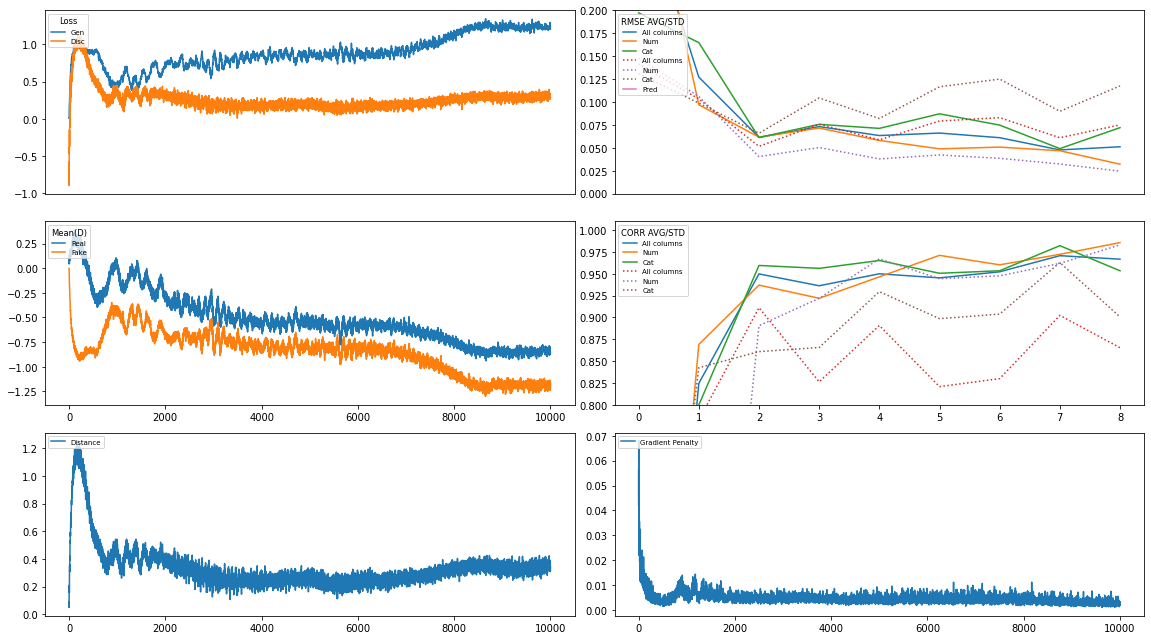

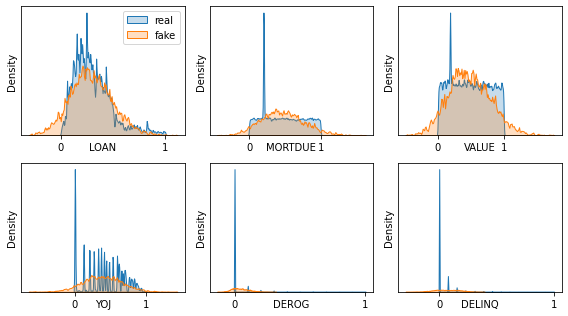

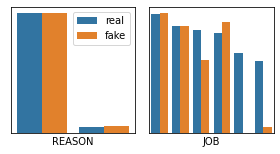

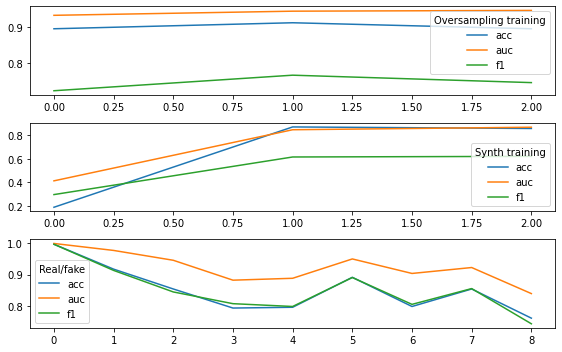

INFO:root:Saving models to Experiments/results/2021-04-06_17-16_OGLY/models. Current iter is 10000.
INFO:root:Saving synthetic data to Experiments/results/2021-04-06_17-16_OGLY/data. Current iter is 10000.


[12500/25200] LG:1.224 LD:0.286 D:0.334 GP:0.003 AC: 0.351 RMSEAVG:0.048 NUM:0.032 SynTraiAuc:0.867 RFAcc:0.775  


INFO:root:Saving models to Experiments/results/2021-04-06_17-16_OGLY/models. Current iter is 15000.


[15000/25200] LG:1.160 LD:0.313 D:0.327 GP:0.001 AC: 0.323 RMSEAVG:0.048 NUM:0.047 SynTraiAuc:0.862 RFAcc:0.845  
[17500/25200] LG:1.063 LD:0.223 D:0.279 GP:0.004 AC: 0.460 RMSEAVG:0.057 NUM:0.047 SynTraiAuc:0.862 RFAcc:0.776  
[20000/25200] LG:1.005 LD:0.301 D:0.351 GP:0.003 AC: 0.325 RMSEAVG:0.046 NUM:0.034 SynTraiAuc:0.859 RFAcc:0.812  


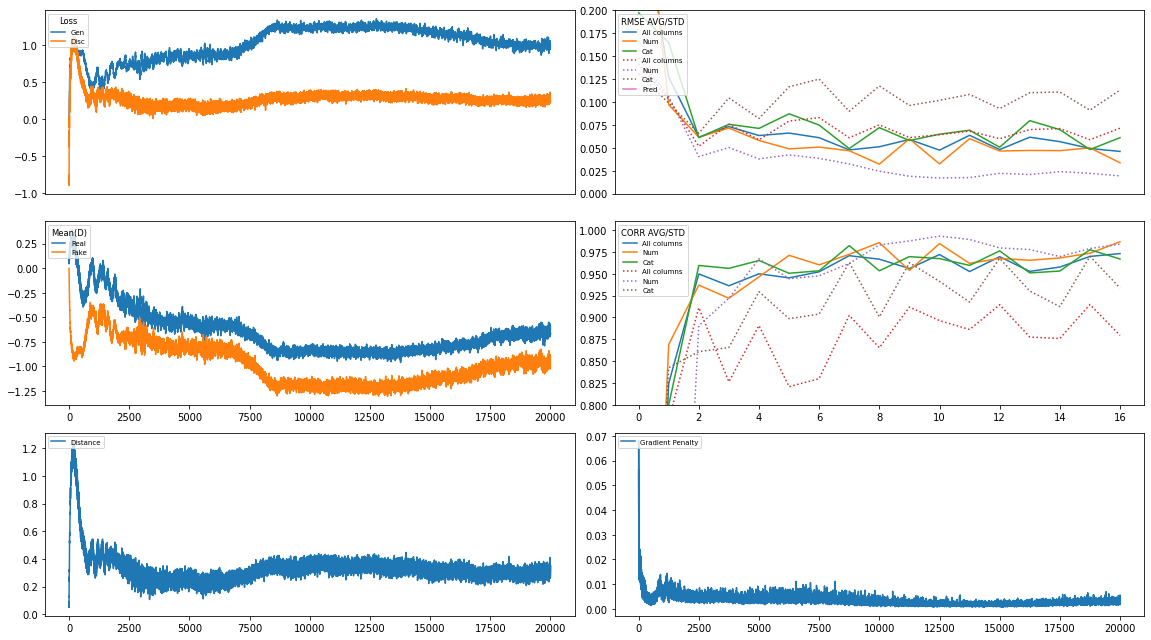

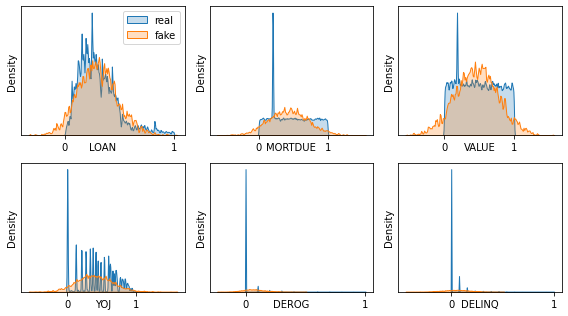

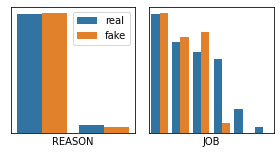

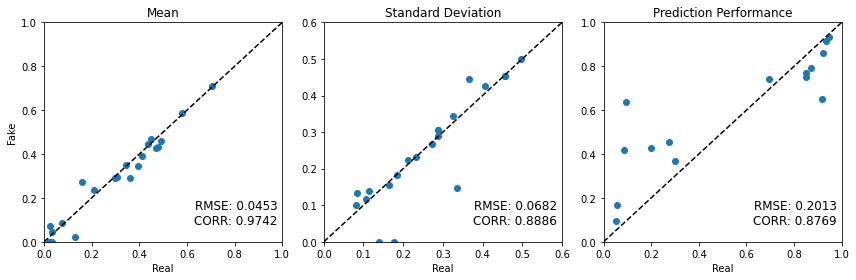

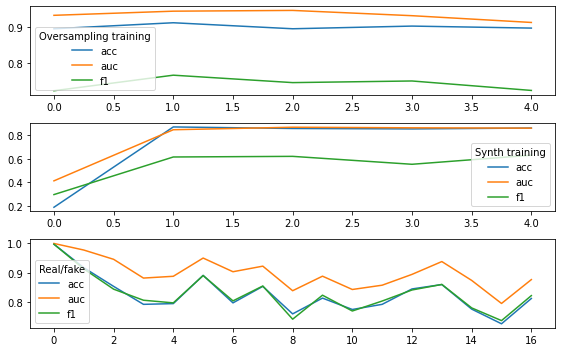

INFO:root:Saving models to Experiments/results/2021-04-06_17-16_OGLY/models. Current iter is 20000.
INFO:root:Saving synthetic data to Experiments/results/2021-04-06_17-16_OGLY/data. Current iter is 20000.


[22500/25200] LG:0.885 LD:0.310 D:0.354 GP:0.003 AC: 0.469 RMSEAVG:0.048 NUM:0.046 SynTraiAuc:0.859 RFAcc:0.765  


INFO:root:Saving models to Experiments/results/2021-04-06_17-16_OGLY/models. Current iter is 25000.


[25000/25200] LG:0.770 LD:0.203 D:0.243 GP:0.003 AC: 0.395 RMSEAVG:0.053 NUM:0.056 SynTraiAuc:0.853 RFAcc:0.873  


INFO:root:Finished training after 25200/25200.
INFO:root:Saving model, data, metrics and plots.


[25200/25200] LG:0.668 LD:0.141 D:0.187 GP:0.003 AC: 0.348 RMSEAVG:0.053 NUM:0.056 SynTraiAuc:0.853 RFAcc:0.873  


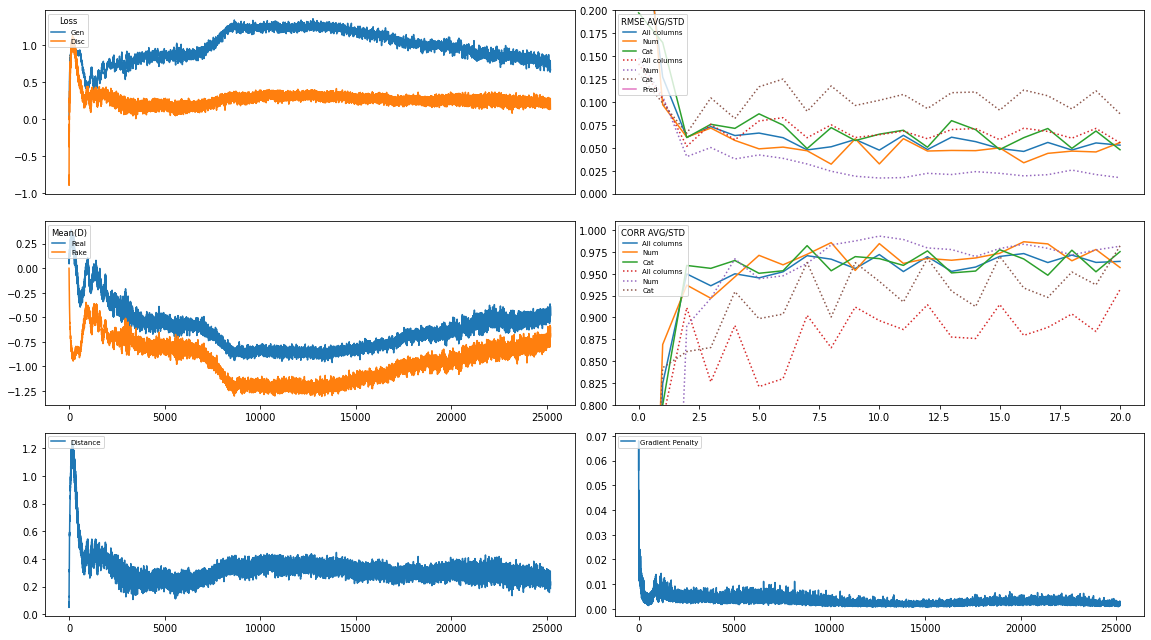

INFO:root:Saving synthetic data to Experiments/results/2021-04-06_17-16_OGLY/data. Current iter is 25200.
INFO:root:Saving metrics to Experiments/results/2021-04-06_17-16_OGLY/metrics. Current iter is 25200.
INFO:root:Saving models to Experiments/results/2021-04-06_17-16_OGLY/models. Current iter is 25200.


Original imbalance ratio was:0.20
After resampling it is:0.50
AUC-ROC Random Forest:
Balanced data:		0.9485
Imbalanced data:	0.9507


In [ ]:
#Performance
from __future__ import division
gan = WGANGP(write_to_disk=True, # whether to create an output folder. Plotting will be surpressed if flase
            compute_metrics_every=1250, print_every=2500, plot_every=10000,
            num_cols = num_cols, cat_dims=cat_dims,
            # pass the one hot encoder to the GAN to enable count plots of categorical variables
            transformer=prep.named_transformers_['cat']['onehotencoder'],
            # pass column names to enable
            cat_cols=cat_cols,
            use_aux_classifier_loss=True,
            d_updates_per_g=3, gp_weight=15)

gan.fit(X_train_trans, y=y_train.values, 
        condition=True,
        epochs=300,  
        batch_size=64,
        netG_kwargs = {'hidden_layer_sizes': (128,64), 
                        'n_cross_layers': 1,
                        'cat_activation': 'gumbel_softmax',
                        'num_activation': 'none',
                        'condition_num_on_cat': True, 
                        'noise_dim': 30, 
                        'normal_noise': False,
                        'activation':  'leaky_relu',
                        'reduce_cat_dim': True,
                        'use_num_hidden_layer': True,
                        'layer_norm':False,},
        netD_kwargs = {'hidden_layer_sizes': (128,64,32),
                        'n_cross_layers': 2,
                        'embedding_dims': 'auto',
                        'activation':  'leaky_relu',
                        'sigmoid_activation': False,
                        'noisy_num_cols': True,
                        'layer_norm':True,}
       )

X_res, y_res = gan.resample(X_train_trans, y=y_train)
print(f'Original imbalance ratio was:{y_train.mean():.2f}\nAfter resampling it is:{y_res.mean():.2f}')

X_test_trans = prep.transform(X_test)

clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', bootstrap=True,
                             random_state=2020, n_jobs=2)

clf.fit(X_res, y_res)
preds_oversampled = clf.predict_proba(X_test_trans)[:,1]

clf.fit(X_train_trans, y_train)
preds_imbalanced = clf.predict_proba(X_test_trans)[:,1]

print(f'AUC-ROC Random Forest:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')

In [ ]:
print(X_res.shape, y_res.shape)

(8592, 21) (8592,)


In [ ]:
#1. 하나의 피쳐 추가하지않고 원래 datset 
#3. latent vector 3 추가 5.cwGAN 으로 oversampling 하여 balance 함
#Random forest

clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', bootstrap=True,
                             random_state=2020, n_jobs=2)

clf.fit(X_res, y_res)
preds_oversampled = clf.predict_proba(X_test_trans)[:,1]

clf.fit(X_train_trans, y_train)
preds_imbalanced = clf.predict_proba(X_test_trans)[:,1]

print(f'AUC-ROC Random Forest:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')

AUC-ROC Random Forest:
Balanced data:		0.9485
Imbalanced data:	0.9507


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 21)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
#criterion
criterion = ['gini', 'entropy']
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 'min_samples_split': [1, 2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result = rf_random.fit(X_res, y_res)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.8min finished


Best Score: 0.9670326365698116
Best Hyperparameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 19, 'criterion': 'gini', 'bootstrap': False}


In [ ]:
#ExtraTree
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', max_depth=None, random_state=2020)

clf.fit(X_res, y_res)
preds_oversampled = clf.predict_proba(X_test_trans)[:,1]

clf.fit(X_train_trans, y_train)
preds_imbalanced = clf.predict_proba(X_test_trans)[:,1]

print(f'AUC-ROC ExtraTreesClassifierr:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')

AUC-ROC ExtraTreesClassifierr:
Balanced data:		0.9665
Imbalanced data:	0.9681


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 21)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 'min_samples_split': [1, 2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
et = ExtraTreesClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
et_random = RandomizedSearchCV(estimator = et, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result = et_random.fit(X_res, y_res)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.7min finished


Best Score: 0.9711172469128097
Best Hyperparameters: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 19, 'bootstrap': True}


In [ ]:
#DecisionTree
from sklearn.tree import DecisionTreeClassifier
clf =  DecisionTreeClassifier(max_depth=None, random_state=2020)

clf.fit(X_res, y_res)
preds_oversampled = clf.predict_proba(X_test_trans)[:,1]

clf.fit(X_train_trans, y_train)
preds_imbalanced = clf.predict_proba(X_test_trans)[:,1]

print(f'AUC-ROC DecisionTreesClassifier:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')

AUC-ROC DecisionTreesClassifier:
Balanced data:		0.8094
Imbalanced data:	0.7948


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 21)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)


{'max_features': ['auto', 'sqrt'], 'max_depth': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 'min_samples_split': [1, 2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result = dt_random.fit(X_res, y_res)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score: 0.900407306914058
Best Hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 11}


[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished


In [ ]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier


clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=2020)

clf.fit(X_res, y_res)
preds_oversampled = clf.predict_proba(X_test_trans)[:,1]

clf.fit(X_train_trans, y_train)
preds_imbalanced = clf.predict_proba(X_test_trans)[:,1]

print(f'AUC-ROC GradientBoostingClassifier:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')

AUC-ROC GradientBoostingClassifier:
Balanced data:		0.9113
Imbalanced data:	0.9222


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Number of trees in gb
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 21)]
max_depth.append(None)

# Minimum number of samples required at each leaf node
learning_rate = [0.01, 0.1, 0.5]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               
               'max_depth': max_depth,
               
               'learning_rate': learning_rate}
print(random_grid)


{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 'learning_rate': [0.01, 0.1, 0.5]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result = gb_random.fit(X_res, y_res)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 52.4min finished


Best Score: 0.9484397594748396
Best Hyperparameters: {'n_estimators': 700, 'max_depth': 1, 'learning_rate': 0.5}


In [ ]:
'''
import xgboost
clf = xgboost.XGBRegressor()

clf.fit(X_res, y_res)
preds_oversampled = clf.predict(X_test_trans)

clf.fit(X_train_trans, y_train)
preds_imbalanced = clf.predict(X_test_trans)

print(f'AUC-ROC XGBoost:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')
'''      

"\nimport xgboost\nclf = xgboost.XGBRegressor()\n\nclf.fit(X_res, y_res)\npreds_oversampled = clf.predict(X_test_trans)\n\nclf.fit(X_train_trans, y_train)\npreds_imbalanced = clf.predict(X_test_trans)\n\nprint(f'AUC-ROC XGBoost:\n'\n      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'\n      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')\n"

In [ ]:
#Logistic regression

from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

clf = LogisticRegression(penalty='l2', C=1.0, random_state=2020)

clf.fit(X_res, y_res)
preds_oversampled = clf.predict_proba(X_test_trans)[:,1]

clf.fit(X_train_trans, y_train)
preds_imbalanced = clf.predict_proba(X_test_trans)[:,1]

print(f'AUC-ROC Logistic Regression:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')

AUC-ROC Logistic Regression:
Balanced data:		0.7839
Imbalanced data:	0.8060


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform


# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [ ]:
model = LogisticRegression(random_state=2020)
# define search
search = RandomizedSearchCV(model, space, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=2020)
# execute search
result = search.fit(X_res, y_res)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9354081989760735
Best Hyperparameters: {'C': 74.41805831686976, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
#After GAN, (8592, ?) (8592,)-X_res, y_res
# MLP for credit scoring with 10-fold cross validation via sklearn - best

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import roc_auc_score
import numpy

# create a function to build a model, required for KerasClassifier
def create_model():
    # create model
 model = Sequential()
 model.add(Dense(36, input_dim=X_res.shape[1], activation='relu'))
 model.add(Dense(13, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
 return model

# fix random seed for reproducibility
seed = 7 
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=100, verbose=0)

# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed) 
results = cross_val_score(model, X_res, y_res, cv=kfold) 
print(results.mean())

0.9273734986782074


In [ ]:
#MLP AUC
model.fit(X_res, y_res, validation_data=(X_test_trans, y_test))
preds_oversampled = model.predict_proba(X_test_trans)[:,1]

model.fit(X_train_trans, y_train)
preds_imbalanced = model.predict_proba(X_test_trans)[:,1]

print(f'AUC-ROC MLP:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')

AUC-ROC MLP:
Balanced data:		0.8753
Imbalanced data:	0.8905


In [ ]:
#SMOTE 도 비교가능
#SMOTE 하기전 original data
from collections import Counter
print(X.shape, y.shape, Counter(y))

(5960, 15) (5960,) Counter({0.0: 4771, 1.0: 1189})


In [ ]:
X.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,en1,en2,en3,REASON,JOB
0,0.0,478.0,276.0,59.0,0.0,0.0,782.0,1.0,9.0,0.0,2.070494,0.803548,0.168172,1.0,2.0
1,1.0,2763.0,1475.0,43.0,0.0,2.0,1519.0,0.0,14.0,0.0,2.240426,1.605950,0.218772,1.0,2.0
2,2.0,143.0,19.0,32.0,0.0,0.0,2188.0,1.0,10.0,0.0,1.838029,0.060537,0.490183,1.0,2.0
3,2.0,1026.0,998.0,0.0,0.0,0.0,980.0,0.0,16.0,0.0,1.694635,1.249705,0.197882,0.0,2.0
4,3.0,3986.0,3694.0,26.0,0.0,0.0,763.0,0.0,14.0,0.0,1.721140,1.893549,0.230451,1.0,1.0


In [ ]:
df.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,en1,en2,en3,BAD
0,0.0,478.0,276.0,1.0,2.0,59.0,0.0,0.0,782.0,1.0,9.0,0.0,2.070494,0.803548,0.168172,1.0
1,1.0,2763.0,1475.0,1.0,2.0,43.0,0.0,2.0,1519.0,0.0,14.0,0.0,2.240426,1.605950,0.218772,1.0
2,2.0,143.0,19.0,1.0,2.0,32.0,0.0,0.0,2188.0,1.0,10.0,0.0,1.838029,0.060537,0.490183,1.0
3,2.0,1026.0,998.0,0.0,2.0,0.0,0.0,0.0,980.0,0.0,16.0,0.0,1.694635,1.249705,0.197882,1.0
4,3.0,3986.0,3694.0,1.0,1.0,26.0,0.0,0.0,763.0,0.0,14.0,0.0,1.721140,1.893549,0.230451,0.0


In [ ]:
#wGAN 으로 resampling 된 dataset
from collections import Counter
print(X_res.shape, y_res.shape, Counter(y_res))

(8592, 21) (8592,) Counter({0.0: 4296, 1.0: 4296})


In [ ]:
#latent vector 를 몇개 할지도 생각할수 있다 - 다른 실험
#아래로는 GAN

In [ ]:
#일반 GAN 과 비교 - Kaggle 에서 한 코드 - 위의 것까지는 cWGAN 결과
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf  
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding  
from keras.layers.advanced_activations import LeakyReLU  
from keras.layers.merge import concatenate  
from keras.models import Sequential, Model  
from keras.optimizers import Adam  
from keras.utils import to_categorical  
from keras.layers.advanced_activations import LeakyReLU  
from keras.utils.vis_utils import plot_model  
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder  
import scipy.stats  
import datetime as dt  
import pydot  
import warnings  
warnings.filterwarnings("ignore")  
%matplotlib inline  

In [ ]:
df.dtypes

LOAN        float64
MORTDUE     float64
VALUE       float64
REASON     category
JOB        category
YOJ         float64
DEROG       float64
DELINQ      float64
CLAGE       float64
NINQ        float64
CLNO        float64
DEBTINC     float64
en1         float64
en2         float64
en3         float64
BAD         float64
dtype: object

In [ ]:
#Categorical
df['REASON'] = df['REASON'].astype(str)  
df['JOB'] = df['JOB'].astype(str)  

df.dtypes

LOAN       float64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
en1        float64
en2        float64
en3        float64
BAD        float64
dtype: object

In [ ]:
df_minority_data=df.loc[df['BAD'] == 1]  
 
#Subsetting input features without target variable
df_minority_data_withouttv=df_minority_data.loc[:, df_minority_data.columns != 'BAD']
numerical_df = df_minority_data_withouttv.select_dtypes("float64")  
categorical_df = df_minority_data_withouttv.select_dtypes("object")  
scaling = MinMaxScaler()  
numerical_df_rescaled = scaling.fit_transform(numerical_df)  
get_dummy_df = pd.get_dummies(categorical_df)    

Reason_dummy_col = [col for col in get_dummy_df.columns if 'REASON' in col]  
Reason_dummy = get_dummy_df[Reason_dummy_col]  
Job_dummy_col = [col for col in get_dummy_df.columns if 'JOB' in col]  
Job_dummy = get_dummy_df[Job_dummy_col]  

In [ ]:
def define_generator (catsh1,catsh2,numerical):    
  #Inputting noise  from latent space
    noise = Input(shape = (100,))    
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)    
    hidden_1 = LeakyReLU(0.2)(hidden_1)    
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)    
    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)    
    hidden_2 = LeakyReLU(0.2)(hidden_2)    
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)    

    #Branch 1 for generating location data

    branch_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)    
    branch_1 = LeakyReLU(0.2)(branch_1)    
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)    
    branch_1 = Dense(64, kernel_initializer = "he_uniform")(branch_1)    
    branch_1 = LeakyReLU(0.2)(branch_1)    
    branch_1 = BatchNormalization(momentum=0.8)(branch_1)    
 
    #Output Layer1
    branch_1_output = Dense(catsh1, activation = "softmax")(branch_1)  

    #Likewise, for all remaining 3 categories branches will be defined 

    #Branch 2 for generating location data

    branch_2 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)    
    branch_2 = LeakyReLU(0.2)(branch_2)    
    branch_2 = BatchNormalization(momentum = 0.8)(branch_2)    
    branch_2 = Dense(64, kernel_initializer = "he_uniform")(branch_2)    
    branch_2 = LeakyReLU(0.2)(branch_2)    
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)    
 
    #Output Layer1
    branch_2_output = Dense(catsh2, activation = "softmax")(branch_2)

    #Branch 12 for generating numerical data 
    branch_12 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    branch_12 = Dense(128, kernel_initializer = "he_uniform")(branch_12)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    
    #Output Layer12 
    branch_12_output = Dense(numerical, activation = "sigmoid")(branch_12)    

    #Combined output 
    combined_output = concatenate([branch_1_output, branch_2_output, branch_12_output])
    #Return model 

    return Model(inputs = noise, outputs = combined_output)    

    
generator = define_generator(Reason_dummy.shape[1],Job_dummy.shape[1], numerical_df_rescaled.shape[1])  
generator.summary()  


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 8)            808         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 8)            0           dense_40[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8)            32          leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [ ]:
def define_discriminator(inputs_n):  
    #Input from generator
    d_input = Input(shape = (inputs_n,))    
    d = Dense(128, kernel_initializer="he_uniform")(d_input)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(64, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(32, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(16, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(8, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  

    #Output Layer
    d_output = Dense(1, activation = "sigmoid")(d)  

    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)  
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])  
    return model  


inputs_n = Reason_dummy.shape[1]+Job_dummy.shape[1]+numerical_df_rescaled.shape[1]  
discriminator = define_discriminator(inputs_n)  
discriminator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               2816      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32)                0   

Epoch: 200 [Discriminator loss: 0.468641] [Generator loss: 1.915586]
Epoch: 400 [Discriminator loss: 0.633053] [Generator loss: 1.151152]
Epoch: 600 [Discriminator loss: 0.577267] [Generator loss: 0.937145]
Epoch: 800 [Discriminator loss: 0.523651] [Generator loss: 0.885754]
Epoch: 1000 [Discriminator loss: 0.664473] [Generator loss: 0.815749]
Epoch: 1200 [Discriminator loss: 0.647618] [Generator loss: 0.797821]
Epoch: 1400 [Discriminator loss: 0.684812] [Generator loss: 0.760633]
Epoch: 1600 [Discriminator loss: 0.596228] [Generator loss: 0.868386]
Epoch: 1800 [Discriminator loss: 0.638491] [Generator loss: 0.787009]
Epoch: 2000 [Discriminator loss: 0.647751] [Generator loss: 0.837333]
Epoch: 2200 [Discriminator loss: 0.705941] [Generator loss: 0.778311]
Epoch: 2400 [Discriminator loss: 0.629514] [Generator loss: 0.824144]
Epoch: 2600 [Discriminator loss: 0.649070] [Generator loss: 0.819059]
Epoch: 2800 [Discriminator loss: 0.669923] [Generator loss: 0.804487]
Epoch: 3000 [Discriminat

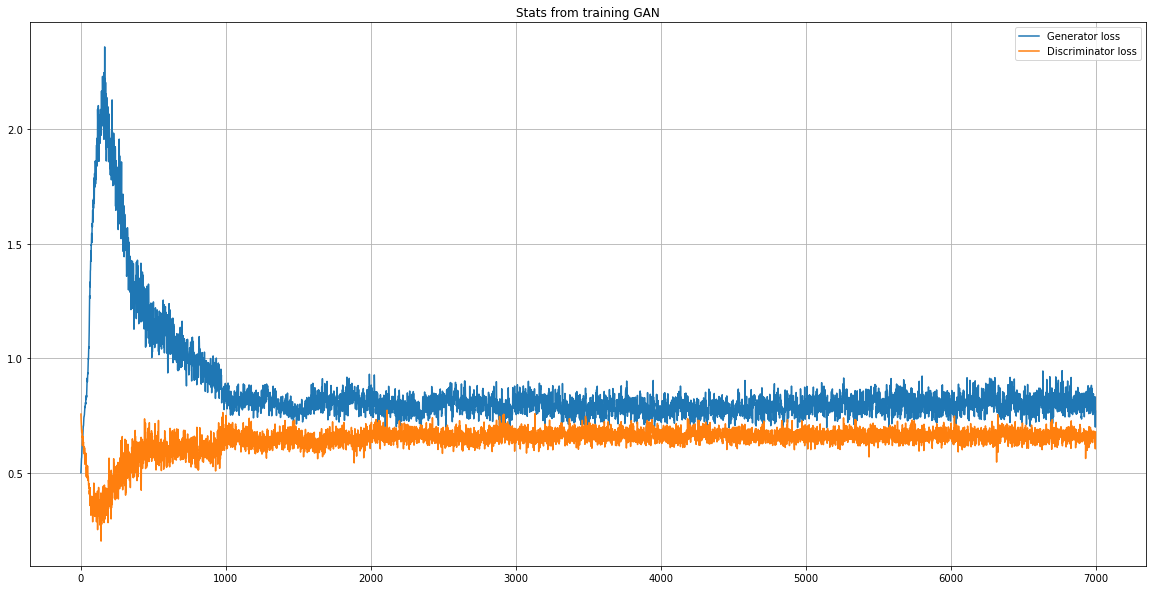

In [ ]:
def define_complete_gan(generator, discriminator):  
    discriminator.trainable = False  
    gan_output = discriminator(generator.output)  
    
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)  

    #Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))  
    return model  

completegan = define_complete_gan(generator, discriminator)

def gan_train(gan, generator, discriminator, catsh1,catsh2,numerical, latent_dim, n_epochs, n_batch, n_eval):  
    #Upddte Discriminator with half batch size
    half_batch = int(n_batch / 2)  
    discriminator_loss = []  
    generator_loss = []  
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))  
    y_gan = np.ones((n_batch, 1))  
    fake = np.zeros((half_batch, 1))  

     #training
    for i in range(n_epochs):  
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, catsh1.shape[0], half_batch)       
        Reason_real = catsh1[idx]  
        Job_real = catsh2[idx]  
        numerical_real = numerical_df_rescaled[idx]  

        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([Reason_real, Job_real, numerical_real], axis = 1)

        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))  
        fake_data = generator.predict(noise)  
     
        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)  
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)  
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
        discriminator_loss.append(d_loss)  
       
        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))  
        g_loss = gan.train_on_batch(noise, y_gan)  
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:  
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))  
            
    plt.figure(figsize = (20, 10))  
    plt.plot(generator_loss, label = "Generator loss")  
    plt.plot(discriminator_loss, label = "Discriminator loss")     
    plt.title("Stats from training GAN")  
    plt.grid()  
    plt.legend() 

latent_dim = 100  
gan_train(completegan, generator, discriminator, Reason_dummy.values,Job_dummy.values, numerical_df_rescaled, latent_dim, n_epochs = 7000, n_batch = 63, n_eval = 200)



In [ ]:
noise = np.random.normal(0, 1, (3582, 100))  
generated_mixed_data = generator.predict(noise)  
columns=list(Reason_dummy.columns)+list(Job_dummy.columns)+list(numerical_df.columns)  
mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)  
 


#Original Data
original_df = pd.concat([Reason_dummy,Job_dummy,numerical_df], axis = 1)  

Numeric_columns=numerical_df.columns  


In [ ]:
##generated minority class - 3582
mixed_gen_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3582 entries, 0 to 3581
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   REASON_0.0  3582 non-null   float32
 1   REASON_1.0  3582 non-null   float32
 2   JOB_0.0     3582 non-null   float32
 3   JOB_1.0     3582 non-null   float32
 4   JOB_2.0     3582 non-null   float32
 5   JOB_3.0     3582 non-null   float32
 6   JOB_4.0     3582 non-null   float32
 7   JOB_5.0     3582 non-null   float32
 8   LOAN        3582 non-null   float32
 9   MORTDUE     3582 non-null   float32
 10  VALUE       3582 non-null   float32
 11  YOJ         3582 non-null   float32
 12  DEROG       3582 non-null   float32
 13  DELINQ      3582 non-null   float32
 14  CLAGE       3582 non-null   float32
 15  NINQ        3582 non-null   float32
 16  CLNO        3582 non-null   float32
 17  DEBTINC     3582 non-null   float32
 18  en1         3582 non-null   float32
 19  en2         3582 non-null  

In [ ]:
#minority class - 1189
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189 entries, 0 to 5934
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   REASON_0.0  1189 non-null   uint8  
 1   REASON_1.0  1189 non-null   uint8  
 2   JOB_0.0     1189 non-null   uint8  
 3   JOB_1.0     1189 non-null   uint8  
 4   JOB_2.0     1189 non-null   uint8  
 5   JOB_3.0     1189 non-null   uint8  
 6   JOB_4.0     1189 non-null   uint8  
 7   JOB_5.0     1189 non-null   uint8  
 8   LOAN        1189 non-null   float64
 9   MORTDUE     1189 non-null   float64
 10  VALUE       1189 non-null   float64
 11  YOJ         1189 non-null   float64
 12  DEROG       1189 non-null   float64
 13  DELINQ      1189 non-null   float64
 14  CLAGE       1189 non-null   float64
 15  NINQ        1189 non-null   float64
 16  CLNO        1189 non-null   float64
 17  DEBTINC     1189 non-null   float64
 18  en1         1189 non-null   float64
 19  en2         1189 non-null  

In [ ]:
'''
#생성된 분포 원래 분포와 확인

mixed_gen_df.iloc[:,:-3] = np.round(mixed_gen_df.iloc[:,:-3])  
mixed_gen_df.iloc[:,-2:] = scaling.inverse_transform(mixed_gen_df.iloc[:,-2:])  

def normal_distribution(org, noise):  
    org_x = np.linspace(org.min(), org.max(), len(org))  
    noise_x = np.linspace(noise.min(), noise.max(), len(noise))  
    org_y = scipy.stats.norm.pdf(org_x, org.mean(), org.std())  
    noise_y = scipy.stats.norm.pdf(noise_x, noise.mean(), noise.std())  
    n, bins, patches = plt.hist([org, noise], density = True, alpha = 0.5, color = ["green", "red"])  
    xmin, xmax = plt.xlim()  
    plt.plot(org_x, org_y, color = "green", label = "Original data", alpha = 0.5)  
    plt.plot(noise_x, noise_y, color = "red", label = "Generated data", alpha = 0.5)  
    title = f"Original data mean {np.round(org.mean(), 4)}, Original data std {np.round(org.std(), 4)}, Original data var {np.round(org.var(), 4)}\nGenerated data mean {np.round(noise.mean(), 4)}, Generated data {np.round(noise.std(), 4)}, Generated data var {np.round(noise.var(), 2)}"
    plt.title(title)  
    plt.legend()  
    plt.grid()  
    plt.show()  

Numeric_columns=numerical_df.columns  

for column in numerical_df.columns:  
    print(column, "Comparison between Original Data and Generated Data")  
    normal_distribution(original_df
, mixed_gen_df
)
'''

'\n#생성된 분포 원래 분포와 확인\n\nmixed_gen_df.iloc[:,:-3] = np.round(mixed_gen_df.iloc[:,:-3])  \nmixed_gen_df.iloc[:,-2:] = scaling.inverse_transform(mixed_gen_df.iloc[:,-2:])  \n\ndef normal_distribution(org, noise):  \n    org_x = np.linspace(org.min(), org.max(), len(org))  \n    noise_x = np.linspace(noise.min(), noise.max(), len(noise))  \n    org_y = scipy.stats.norm.pdf(org_x, org.mean(), org.std())  \n    noise_y = scipy.stats.norm.pdf(noise_x, noise.mean(), noise.std())  \n    n, bins, patches = plt.hist([org, noise], density = True, alpha = 0.5, color = ["green", "red"])  \n    xmin, xmax = plt.xlim()  \n    plt.plot(org_x, org_y, color = "green", label = "Original data", alpha = 0.5)  \n    plt.plot(noise_x, noise_y, color = "red", label = "Generated data", alpha = 0.5)  \n    title = f"Original data mean {np.round(org.mean(), 4)}, Original data std {np.round(org.std(), 4)}, Original data var {np.round(org.var(), 4)}\nGenerated data mean {np.round(noise.mean(), 4)}, Generated data {

In [ ]:
# Getting Back Categorical Data in Original_Format from Dummies
Reason_filter_col = [col for col in mixed_gen_df if col.startswith('REASON')]  
Reason=mixed_gen_df[Reason_filter_col]   
Reason= pd.get_dummies(Reason).idxmax(1)  
Reason= Reason.replace('REASON_', '', regex=True)  
df_generated_data = pd.DataFrame()   
df_generated_data['REASON']=Reason 

Job_filter_col = [col for col in mixed_gen_df if col.startswith('JOB')]  
Job=mixed_gen_df[Job_filter_col]   
Job= pd.get_dummies(Job).idxmax(1)  
Job= Job.replace('JOB_', '', regex=True)  
df_generated_data['JOB']=Job  

df_generated_data['BAD']=1  
df_generated_data['BAD']=1  

df_generated_data[['LOAN','MORTDUE', 'VALUE', 'YOJ', 'DEROG']]=mixed_gen_df[['LOAN','MORTDUE', 'VALUE', 'YOJ', 'DEROG']]  
df_generated_data = df_generated_data.fillna(np.nan,axis=0)

df_generated_data[['DELINQ','CLAGE', 'NINQ', 'CLNO', 'DEBTINC']]=mixed_gen_df[['DELINQ','CLAGE', 'NINQ', 'CLNO', 'DEBTINC']]  
df_generated_data = df_generated_data.fillna(np.nan,axis=0)

df_generated_data[['en1', 'en2', 'en3']]=mixed_gen_df[['en1','en2', 'en3']]  
df_generated_data = df_generated_data.fillna(np.nan,axis=0)

#Encoding Data
encoder_Reason = LabelEncoder()  
encoder_Job = LabelEncoder()   

# Loading and Encoding original Data   
df['REASON'] = encoder_Reason.fit_transform(df['REASON'].astype(str))  
df['JOB'] = encoder_Job.fit_transform(df['JOB'].astype(str))  

# Encoding Generated Data  
df_generated_data['REASON'] = encoder_Reason.transform(df_generated_data['REASON'].astype(str))  
df_generated_data['JOB'] = encoder_Job.transform(df_generated_data['JOB'].astype(str))  


In [ ]:
df_generated_data.head()

,REASON,JOB,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,en1,en2,en3
0,0,3,1,0.346506,0.422845,0.583725,0.565906,0.062682,0.001630,0.051795,0.011013,0.556684,0.043011,0.452513,0.693316,0.226024
1,0,2,1,0.308708,0.216192,0.122911,0.198434,0.007330,0.009690,0.091756,0.593285,0.330911,0.004191,0.532111,0.541469,0.088674
2,0,2,1,0.535929,0.644556,0.893272,0.662363,0.010450,0.346357,0.388236,0.019801,0.406543,0.003404,0.248895,0.505947,0.055449
3,0,2,1,0.201657,0.163420,0.130278,0.529790,0.000082,0.001340,0.191145,0.120845,0.435107,0.866935,0.404292,0.771981,0.820858
4,0,2,1,0.337363,0.057655,0.050253,0.310046,0.045290,0.158178,0.340041,0.467181,0.301542,0.000038,0.499900,0.188600,0.035019


In [ ]:
df_generated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3582 entries, 0 to 3581
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   REASON   3582 non-null   int64  
 1   JOB      3582 non-null   int64  
 2   BAD      3582 non-null   int64  
 3   LOAN     3582 non-null   float32
 4   MORTDUE  3582 non-null   float32
 5   VALUE    3582 non-null   float32
 6   YOJ      3582 non-null   float32
 7   DEROG    3582 non-null   float32
 8   DELINQ   3582 non-null   float32
 9   CLAGE    3582 non-null   float32
 10  NINQ     3582 non-null   float32
 11  CLNO     3582 non-null   float32
 12  DEBTINC  3582 non-null   float32
 13  en1      3582 non-null   float32
 14  en2      3582 non-null   float32
 15  en3      3582 non-null   float32
dtypes: float32(13), int64(3)
memory usage: 266.0 KB


In [ ]:
df.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,en1,en2,en3,BAD
0,0.0,478.0,276.0,1,2,59.0,0.0,0.0,782.0,1.0,9.0,0.0,2.070494,0.803548,0.168172,1.0
1,1.0,2763.0,1475.0,1,2,43.0,0.0,2.0,1519.0,0.0,14.0,0.0,2.240426,1.605950,0.218772,1.0
2,2.0,143.0,19.0,1,2,32.0,0.0,0.0,2188.0,1.0,10.0,0.0,1.838029,0.060537,0.490183,1.0
3,2.0,1026.0,998.0,0,2,0.0,0.0,0.0,980.0,0.0,16.0,0.0,1.694635,1.249705,0.197882,1.0
4,3.0,3986.0,3694.0,1,1,26.0,0.0,0.0,763.0,0.0,14.0,0.0,1.721140,1.893549,0.230451,0.0


In [ ]:
print(df.shape, df_generated_data.shape)

(5960, 16) (3582, 16)


In [ ]:
df_generated_data['BAD'].groupby

<bound method Series.groupby of 0       1
1       1
2       1
3       1
4       1
       ..
3577    1
3578    1
3579    1
3580    1
3581    1
Name: BAD, Length: 3582, dtype: int64>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
import os

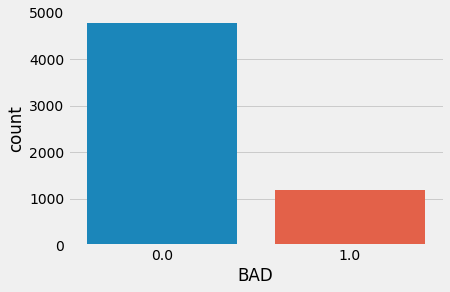

In [ ]:
# 원래 dataset class 분포
plt.figure(figsize=(6,4))
sns.countplot("BAD", data=df)

In [ ]:
df_balanced =df.append(df_generated_data, sort=False)  

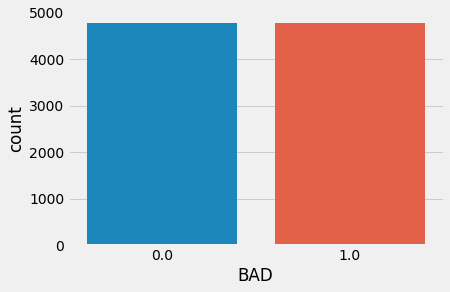

In [ ]:
#GAN 으로 minority class 를 생성하여 dataset 을 balanced 했음
plt.figure(figsize=(6,4))
sns.countplot("BAD", data=df_balanced)

In [ ]:
#performance check of GAN
from sklearn.metrics import recall_score as rs  
from sklearn.metrics import precision_score as ps  
from sklearn.metrics import f1_score as fs  
from sklearn.metrics import balanced_accuracy_score as bas  
from sklearn.metrics import confusion_matrix as cm  
import numpy as np  
import pandas as pd  
import datetime as dt  
import sklearn  
from scipy import stats  
from sklearn import preprocessing  
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import recall_score as rs  
from sklearn.metrics import precision_score as ps  
from sklearn.metrics import f1_score as fs  
from sklearn.metrics import log_loss  

#Seperate TV in Generated Data
X1 = df_generated_data.loc[:, df_generated_data.columns != 'BAD']  
Y1 = df_generated_data['BAD']  

#Seperate TV in Original Data
X = df.loc[:, df.columns != 'BAD']  
Y = df['BAD']  


In [ ]:
#Splitting Original Data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1,random_state=2020)  

#Appending Generated Data(X1, Y1) to X_train and Y_train
X_train1=X_train.append(X1, sort=False)  
Y_train1=Y_train.append(Y1)  


In [ ]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8946 entries, 4292 to 3581
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   LOAN     8946 non-null   float64
 1   MORTDUE  8946 non-null   float64
 2   VALUE    8946 non-null   float64
 3   REASON   8946 non-null   int64  
 4   JOB      8946 non-null   int64  
 5   YOJ      8946 non-null   float64
 6   DEROG    8946 non-null   float64
 7   DELINQ   8946 non-null   float64
 8   CLAGE    8946 non-null   float64
 9   NINQ     8946 non-null   float64
 10  CLNO     8946 non-null   float64
 11  DEBTINC  8946 non-null   float64
 12  en1      8946 non-null   float64
 13  en2      8946 non-null   float64
 14  en3      8946 non-null   float64
dtypes: float64(13), int64(2)
memory usage: 1.1 MB


In [ ]:
print(Y_train1.shape)

(8946,)


In [ ]:
#Random forest

rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', bootstrap=True,
                             random_state=2020, n_jobs=2)

rf.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
preds_oversampled = rf.predict_proba(X_test)[:,1]

rf.fit(X_train, Y_train)
preds_imbalanced = rf.predict_proba(X_test)[:,1]

print(f'AUC-ROC Random Forest:\n'
      f'Balanced data:\t\t{roc_auc_score(Y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(Y_test, preds_imbalanced):.4f}')


AUC-ROC Random Forest:
Balanced data:		0.9450
Imbalanced data:	0.9478


In [ ]:
def plot_feature_importances(model):
    plt.figure(figsize=(8,6))
    n_features = X_train1.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train1.columns)
    plt.xlabel("Comparison of Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

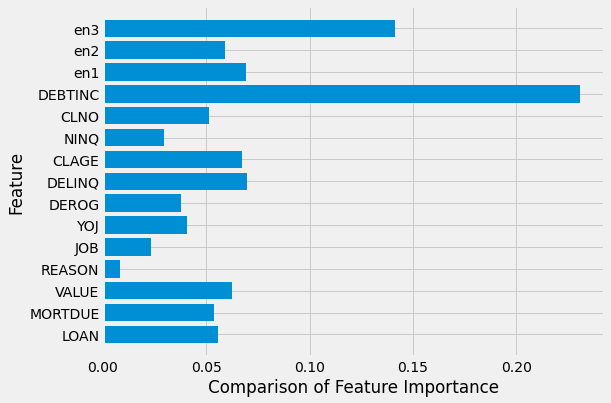

In [ ]:
plot_feature_importances(rf)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
#criterion
criterion = ['gini', 'entropy']
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None], 'min_samples_split': [1, 2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result = rf_random.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.6min finished


Best Score: 0.9576558088544482
Best Hyperparameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'entropy', 'bootstrap': True}


In [ ]:
'''
# Computing the importance of each feature 
feature_importance = clf.feature_importances_ 
# Normalizing the individual importances 
rf_feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_], 
                                        axis = 0) 
'''                                        

In [ ]:
#Extratree
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', max_depth=None, random_state=2020)

'''
clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', bootstrap=True,
                             random_state=2020, n_jobs=2)
'''

et.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
preds_oversampled = et.predict_proba(X_test)[:,1]

et.fit(X_train, Y_train)
preds_imbalanced = et.predict_proba(X_test)[:,1]

print(f'AUC-ROC Random Forest:\n'
      f'Balanced data:\t\t{roc_auc_score(Y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(Y_test, preds_imbalanced):.4f}')


In [ ]:
'''
# Computing the importance of each feature 
feature_importance = clf.feature_importances_ 
# Normalizing the individual importances 
et_feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_], 
                                        axis = 0) 
'''                                        

In [ ]:
'''
# Plotting a Bar Graph to compare the models 
plt.bar(X_train1, et_feature_importance_normalized) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances for Extra Trees') 
plt.title('Comparison of different Feature Importances') 
plt.show() 
'''

In [ ]:
plot_feature_importances(et)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Number of trees in extra trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
et = ExtraTreesClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
et_random = RandomizedSearchCV(estimator = et, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=2020, n_jobs = -1)
# Fit the random search model
result = et_random.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt =  DecisionTreeClassifier(max_depth=None, random_state=2020)

dt.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
preds_oversampled = dt.predict_proba(X_test)[:,1]

dt.fit(X_train, Y_train)
preds_imbalanced = dt.predict_proba(X_test)[:,1]

print(f'AUC-ROC Random Forest:\n'
      f'Balanced data:\t\t{roc_auc_score(Y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(Y_test, preds_imbalanced):.4f}')

In [ ]:
'''
# Computing the importance of each feature 
feature_importance = clf.feature_importances_ 
# Normalizing the individual importances 
dt_feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_], 
                                        axis = 0) 
'''                                        

In [ ]:
'''
# Plotting a Bar Graph to compare the models 
plt.bar(X_train1, dt_feature_importance_normalized) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances for Decision Tree') 
plt.title('Comparison of different Feature Importances') 
plt.show() 
'''

In [ ]:
plot_feature_importances(dt)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=2020, n_jobs = -1)
# Fit the random search model
result = dt_random.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
#Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=2020)

gb.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
preds_oversampled = gb.predict_proba(X_test)[:,1]

gb.fit(X_train, Y_train)
preds_imbalanced = gb.predict_proba(X_test)[:,1]

print(f'AUC-ROC GradientBoostingClassifier:\n'
      f'Balanced data:\t\t{roc_auc_score(Y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(Y_test, preds_imbalanced):.4f}')

In [ ]:
'''plot_feature_importances(dt)'''

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Number of trees in gb
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)

# Minimum number of samples required at each leaf node
learning_rate = [0.01, 0.1, 0.5]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               
               'max_depth': max_depth,
               
               'learning_rate': learning_rate}
print(random_grid)


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=2020, n_jobs = -1)
# Fit the random search model
result = gb_random.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
'''
import numpy as np

n_features = X_train1.shape[1]

gt_i=dt.feature_importances_
et_i=et.feature_importances_
rf_i=rf.feature_importances_
gb_i=gb.feature_importances_

plt.figure(figsize=(18,16))
ind = np.arange(n_features) 
width = 0.15
plt.bar(ind, gt_i, width, label='Decision Trees')
plt.bar(ind+width, et_i, width, label='Extra Trees')
plt.bar(ind+width+width, rf_i, width, label='Random Forest')
plt.bar(ind+width+width+width, gb_i, width, label='Gradient Boosting')

plt.ylabel('Feature importance')
plt.title('Comparison of feature importance on tree-based models')

plt.xticks(np.arange(n_features), X_train1.columns)
plt.legend(loc='best')
plt.show()
'''

In [ ]:
'''
import numpy as np

n_features = X_train1.shape[1]

gt_i=dt.feature_importances_
et_i=et.feature_importances_
rf_i=rf.feature_importances_
gb_i=gb.feature_importances_

plt.figure(figsize=(16,14))
ind = np.arange(n_features) 
width = 0.20
plt.barh(ind, gt_i, width, label='Decision Trees')
plt.barh(ind+width, et_i, width, label='Extra Trees')
plt.barh(ind+width+width, rf_i, width, label='Random Forest')
plt.barh(ind+width+width+width, gb_i, width, label='Gradient Boosting')

plt.xlabel('Feature importance')
plt.title('Comparison of feature importance on tree-based models')
plt.yticks(np.arange(n_features), X_train1.columns)
plt.legend(loc='best')
plt.show()
'''

In [ ]:
'''
# Computing the importance of each feature 
feature_importance = clf.feature_importances_ 
# Normalizing the individual importances 
gb_feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_], 
                                        axis = 0) 
'''                                        

'\n# Computing the importance of each feature \nfeature_importance = clf.feature_importances_ \n# Normalizing the individual importances \ngb_feature_importance_normalized = np.std([tree.feature_importances_ for tree in \n                                        clf.estimators_], \n                                        axis = 0) \n'

In [ ]:
'''
# Plotting a Bar Graph to compare the models 
plt.bar(X_train1, gb_feature_importance_normalized) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances for Gradient Boosting') 
plt.title('Comparison of different Feature Importances') 
plt.show() 
'''

In [ ]:
'''
import xgboost
clf = xgboost.XGBRegressor()

clf.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
preds_oversampled = clf.predict(X_test)

clf.fit(X_train, Y_train)
preds_imbalanced = clf.predict(X_test)

print(f'AUC-ROC XGBoost:\n'
      f'Balanced data:\t\t{roc_auc_score(Y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(Y_test, preds_imbalanced):.4f}')
'''      

In [ ]:
#LR

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2', C=1.0, random_state=2020)

clf.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
preds_oversampled = clf.predict_proba(X_test)[:,1]

clf.fit(X_train, Y_train)
preds_imbalanced = clf.predict_proba(X_test)[:,1]

print(f'AUC-ROC Logistic Regression:\n'
      f'Balanced data:\t\t{roc_auc_score(Y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(Y_test, preds_imbalanced):.4f}')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [ ]:
model = LogisticRegression(random_state=2020)
# define search
search = RandomizedSearchCV(model, space, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=2020)
# execute search
result = search.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
#MLP ACC

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import roc_auc_score
import numpy

# create a function to build a model, required for KerasClassifier
def create_model():
    # create model
 model = Sequential()
 model.add(Dense(36, input_dim=X_res.shape[1], activation='relu'))
 model.add(Dense(13, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
 return model

# fix random seed for reproducibility
seed = 7 
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=100, verbose=0)

# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed) 
results = cross_val_score(model, X_res, y_res, cv=kfold) 
print(results.mean())

In [ ]:
#Appending Generated Data to original X
X_balanced=X.append(X1, sort=False)  
Y_balanced=Y.append(Y1)  


In [ ]:
#4771 + 4771 = 9542
print(X_balanced.shape)

In [ ]:
X_balanced.info()

In [ ]:
Y_balanced.groupby

In [ ]:
#SMOTE 하기전 original data with 3 latent vector
from collections import Counter
print(X.shape, y.shape, Counter(y))


In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [ ]:
smk = SMOTETomek(ratio=1)
X_res100, y_res100 = smk.fit_sample(X, Y)

In [ ]:
print(X_res100.shape, y_res100.shape, Counter(y_res100))

In [ ]:
#SMOTE-Check overfitted in SMOTE

In [ ]:
#lets make a roc_curve visualization
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

In [ ]:
#LR
#let's first try the penalized model Logit by providing the class_weight="balanced" parameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict #to perform stratified sampling using cv param
from sklearn.metrics import roc_curve, roc_auc_score #AUC score
from sklearn.preprocessing import StandardScaler

X_train1, X_val, y_train1, y_val = train_test_split(X_res100,y_res100, test_size=0.1, random_state=2020)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=2020)

logit = LogisticRegression(penalty='l2', C=1.0)
logit.fit(X_train1, y_train1)
logit_scores_proba = logit.predict_proba(X_train1)
logit_scores = logit_scores_proba[:,1]

fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train1, logit_scores)
plot_roc_curve(fpr_logit,tpr_logit)
print("AUC Score {}".format(roc_auc_score(y_train1,logit_scores)))

#validate with the validation set
logit_scores_proba_val = logit.predict_proba(X_test)
logit_scores_val = logit_scores_proba_val[:,1]

fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_test, logit_scores_val)
plot_roc_curve(fpr_logit_val,tpr_logit_val)
print("AUC Score {}".format(roc_auc_score(y_test,logit_scores_val)))



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [ ]:
model = LogisticRegression(random_state=2020)
# define search
search = RandomizedSearchCV(model, space, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=2020)
# execute search
result = search.fit(X_train1,y_train1)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
#Random Forest with 50 % bad in total
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

forest = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', bootstrap=True,
                             random_state=2020, n_jobs=2)
forest.fit(X_train1,y_train1) 

y_scores_proba = forest.predict_proba(X_train1)
y_scores = y_scores_proba[:,1]

fpr, tpr, thresh = roc_curve(y_train1, y_scores)
plot_roc_curve(fpr,tpr)
print("AUC Score {}".format(roc_auc_score(y_train1,y_scores))) 

#Let's cross validate
y_val_proba = forest.predict_proba(X_test)
y_scores_val = y_val_proba[:,1]

fpr_val, tpr_val, thresh_val = roc_curve(y_test, y_scores_val)
plot_roc_curve(fpr_val,tpr_val)
print("AUC Score {}".format(roc_auc_score(y_test,y_scores_val)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
#criterion
criterion = ['gini', 'entropy']
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion,
               'bootstrap': bootstrap}
print(random_grid)


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result = rf_random.fit(X_train1,y_train1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
#Extratree 
clf = ExtraTreesClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', max_depth=None, random_state=2020)
clf.fit(X_train1,y_train1) 

y_scores_proba = clf.predict_proba(X_train1)
y_scores = y_scores_proba[:,1]

fpr, tpr, thresh = roc_curve(y_train1, y_scores)
plot_roc_curve(fpr,tpr)
print("AUC Score {}".format(roc_auc_score(y_train1,y_scores))) 

#Let's cross validate
y_val_proba = clf.predict_proba(X_test)
y_scores_val = y_val_proba[:,1]

fpr_val, tpr_val, thresh_val = roc_curve(y_test, y_scores_val)
plot_roc_curve(fpr_val,tpr_val)
print("AUC Score {}".format(roc_auc_score(y_test,y_scores_val)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Number of trees in extra trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
et = ExtraTreesClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
et_random = RandomizedSearchCV(estimator = et, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=2020, n_jobs = -1)
# Fit the random search model
result = et_random.fit(X_train1,y_train1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
#Decision tree 
clf = DecisionTreeClassifier(max_depth=None, random_state=2020)
clf.fit(X_train1,y_train1) 

y_scores_proba = clf.predict_proba(X_train1)
y_scores = y_scores_proba[:,1]

fpr, tpr, thresh = roc_curve(y_train1, y_scores)
plot_roc_curve(fpr,tpr)
print("AUC Score {}".format(roc_auc_score(y_train1,y_scores))) 

#Let's cross validate
y_val_proba = clf.predict_proba(X_test)
y_scores_val = y_val_proba[:,1]

fpr_val, tpr_val, thresh_val = roc_curve(y_test, y_scores_val)
plot_roc_curve(fpr_val,tpr_val)
print("AUC Score {}".format(roc_auc_score(y_test,y_scores_val)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result = dt_random.fit(X_train1,y_train1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
#Gradient Boosting with 50 % bad in total
gbc_clf_submission = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=2020)
gbc_clf_submission.fit(X_train1,y_train1)

gbc_clf_proba = gbc_clf_submission.predict_proba(X_train1)
gbc_clf_scores = gbc_clf_proba[:,1]

gbc_val_proba = gbc_clf_submission.predict_proba(X_test)
gbc_val_scores = gbc_val_proba[:,1]

fpr_gbc, tpr_gbc, thresh_gbc = roc_curve(y_train1, gbc_clf_scores)
plot_roc_curve(fpr_gbc, tpr_gbc)
print("AUC Score {}".format(roc_auc_score(y_train1, gbc_clf_scores)))

fpr_gbc_val, tpr_gbc_val, thresh_gbc_val = roc_curve(y_test, gbc_val_scores)
plot_roc_curve(fpr_gbc_val, tpr_gbc_val)
print("AUC Score {}".format(roc_auc_score(y_test, gbc_val_scores))) 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Number of trees in gb
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)

# Minimum number of samples required at each leaf node
learning_rate = [0.01, 0.1, 0.5]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               
               'max_depth': max_depth,
               
               'learning_rate': learning_rate}
print(random_grid)


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingClassifier(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2020)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, scoring='roc_auc', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result = gb_random.fit(X_train1,y_train1)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
'''
# XGBoost with 50 % bad in total 
import xgboost

xgb_clf = xgboost.XGBRegressor()
xgb_clf.fit(X_train1, y_train1)

xgb_clf_pred = xgb_clf.predict(X_train1)
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_train1, xgb_clf_pred)
plot_roc_curve(fpr_xgb, tpr_xgb)
print("AUC Score {}".format(roc_auc_score(y_train1, xgb_clf_pred)))

y_val_pred = xgb_clf.predict(X_test)
fpr_xgb_val, tpr_xgb_val, thresh_xgb_val = roc_curve(y_test, y_val_pred)
plot_roc_curve(fpr_xgb_val,tpr_xgb_val)
print("AUC Score {}".format(roc_auc_score(y_test,y_val_pred)))
'''